# How to FFT and not suck at it
<img src="files/Joseph_Fast_Fourier.jpg" width="300"/>

> The most important numerical algorithm of our lifetime.
>
> -- <cite>Gilbert Strang</cite>

# First, how to python:
- Install python. I prefer to use anaconda: [Anaconda](https://www.anaconda.com/distribution/). If you need help installing, just talk to me.
- I like prototyping and hacking at data in Jupyter notebooks. Read more at [Jupyter](https://jupyter.org/)
- If you get confused about packages, read the docs: [documentation](https://scipy.org/)
- If you are a former matlab user, check this cheat sheet out: [Numpy for Matlab users](https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html)

In [1]:
%matplotlib notebook
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
print("Now you can python") 

# because I don't like being told what to do
import warnings
warnings.filterwarnings('ignore') 

Now you can python


# How to FFT
I'll show how to correctly take an FFT, normalize it, and plot it correctly. First, a couple important things...

## The Fourier Transform
The Fourier transform is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;$X(f) = \int_{-\infty}^{\infty}x(t)e^{-2\pi i f t}dt$

And, it inverse is

&nbsp;&nbsp;&nbsp;&nbsp;$x(t) = \int_{-\infty}^{\infty}X(f)e^{2\pi i f t}df$

Unless you have fancy mathematical software (or use python's symbolic library), computers don't typically perform continuous integrals. So, we have to do this digitally. Also, this is just one convention of how to define the FT. **There is no standard convention.**  So, whatever you are using, be careful and pay attention to what it does. For example, in physics, the most common convention is

&nbsp;&nbsp;&nbsp;&nbsp;$X(f) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}x(t)e^{i \omega t}dt$

And, it inverse is

&nbsp;&nbsp;&nbsp;&nbsp;$x(t) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty}X(f)e^ {-i \omega t}df$

But, all the signs, factors of $\pi$ can be permuted. 

## The Discrete Fourier Transform (colloquially, the FFT)

First, nomenclature. The digital version of a Fourier transform is called a discrete Fourier transform (DFT) since it is performed on discrete samples. From the simple definition below, the DFT computation is typically $O(n^2)$ for computational cost. However, due to the Fast Fourier transform (FFT) algorithms developed, this drops to $O(n\,log(n))$. This is huge, the plot below explaines why. Also, the FFT is most efficient when the data length is a power of 2.





<IPython.core.display.Javascript object>


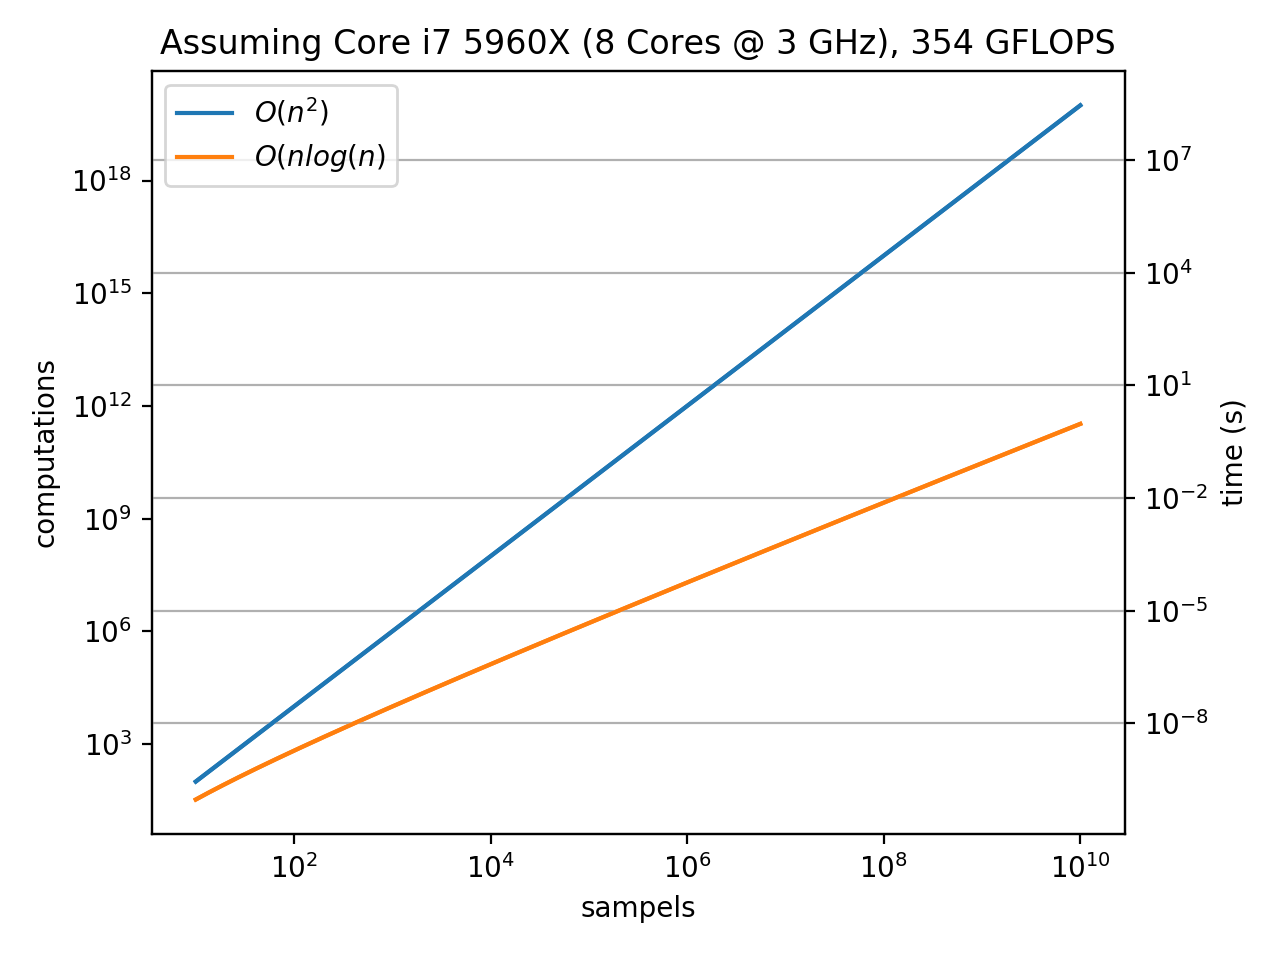

Without the FFT, a 0.94 s computation could take 8.96 years


In [2]:
n = np.logspace(1,10,1000)

_, ax = plt.subplots()
ax.loglog(n,n**2, label = r"$O(n^2)$")
ax.loglog(n,n*np.log2(n), label = r"$O(n log(n)$")
ax.set_xlabel("sampels")
ax.set_ylabel("computations")

ax2 = ax.twinx()
ax2.set_title("Assuming Core i7 5960X (8 Cores @ 3 GHz), 354 GFLOPS")
ax2.loglog(n,n**2 / 354e9, label = r"$O(n^2)$")
ax2.loglog(n,n*np.log2(n) / 354e9, label = r"$O(n log(n)$")
ax2.set_ylabel("time (s)")
ax2.grid()

plt.legend()
plt.tight_layout()
plt.show()

print(f"Without the FFT, a {max(n*np.log2(n) / 354e9):.2f} s computation could take {max(n**2/ 354e9)/60/60/24/365:.2f} years")

<IPython.core.display.Javascript object>


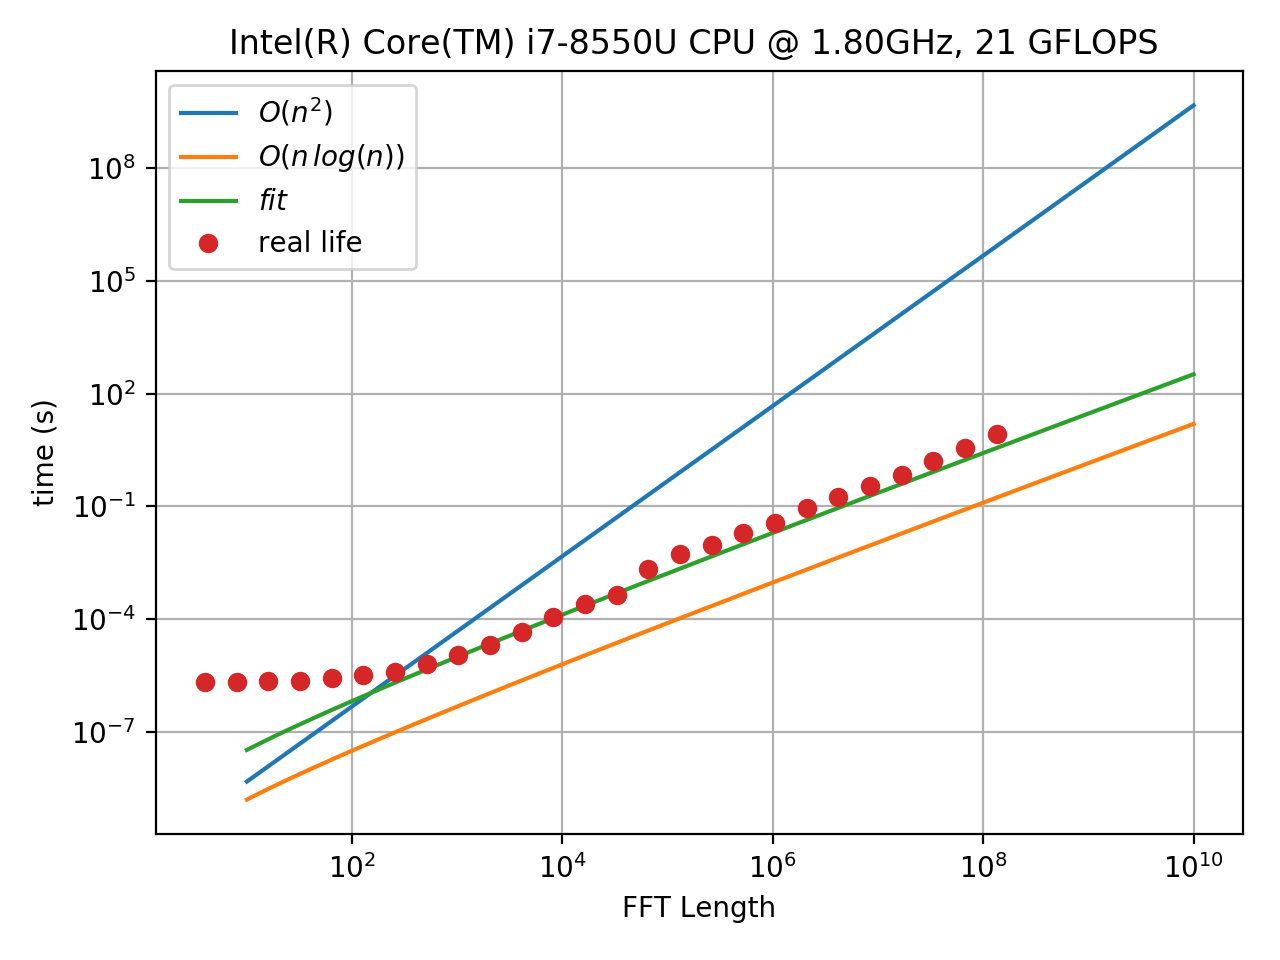

In [3]:
import time
pows = np.arange(2,28,1)

def time_fft(p):
    x = np.random.rand(2**p) + 1j * np.random.rand(2**p)
    temp = %timeit -r 2 -q -o fft.fft(x)
    return temp.average

# This takes a long time, run only once if you mean it
if True:
    times = [time_fft(p) for p in pows]

    _, ax = plt.subplots()
    GFLOPS = 21
    ax.set_title(f"Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, {GFLOPS} GFLOPS ")
    ax.loglog(n,n**2 / GFLOPS/1e9, label = r"$O(n^2)$")
    ax.loglog(n, n*np.log2(n) / GFLOPS/1e9, label = r"$O(n\,log(n))$")
    scale = np.mean(times[8:12] / (2**pows[8:12]*np.log2(2**pows[8:12]) / GFLOPS/1e9))
    ax.loglog(n,scale*n*np.log2(n) / GFLOPS/1e9, label = r"$fit$")
    ax.loglog(2**pows, times, 'o',label= "real life")

    ax.set_ylabel("time (s)")
    ax.set_xlabel("FFT Length")
    ax.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()

## Definitions
For most python librarys, the FFT is defined as:

&nbsp;&nbsp;&nbsp;&nbsp;$X = FFT\{x\}$

&nbsp;&nbsp;&nbsp;&nbsp;$X_k = \sum_{n=0}^{N-1} x_n\cdot e^{-i\frac{2 \pi}{N}kn}$

And, the inverse FFT as:

&nbsp;&nbsp;&nbsp;&nbsp;$x = iFFT\{X\}$

&nbsp;&nbsp;&nbsp;&nbsp;$x_n = \frac{1}{N} \sum_{n=0}^{N-1} X_k\cdot e^{i\frac{ 2 \pi}{N}kn}$

**The default normalization has the direct transforms unscaled and the inverse transforms are scaled by $1/n$. It is possible to obtain unitary transforms by setting the keyword argument norm to "ortho" (default is None) so that both direct and inverse transforms will be scaled by $1/\sqrt{n}$.**

It is also important to notice that there is a factor of $2\pi$ in the exponent for both the $FFT$ and the $iFFT$. So, when using it, you will generally need to be using angular units for everything. Most of us think in Hertz. So, a frequency $f$ in Hertz is translated to angular units using the relation

&nbsp;&nbsp;&nbsp;&nbsp; $\omega = 2 \pi f$, 

where $\omega$ is angular frequency (radians/second) instead of Hertz (cycles/second).

<IPython.core.display.Javascript object>


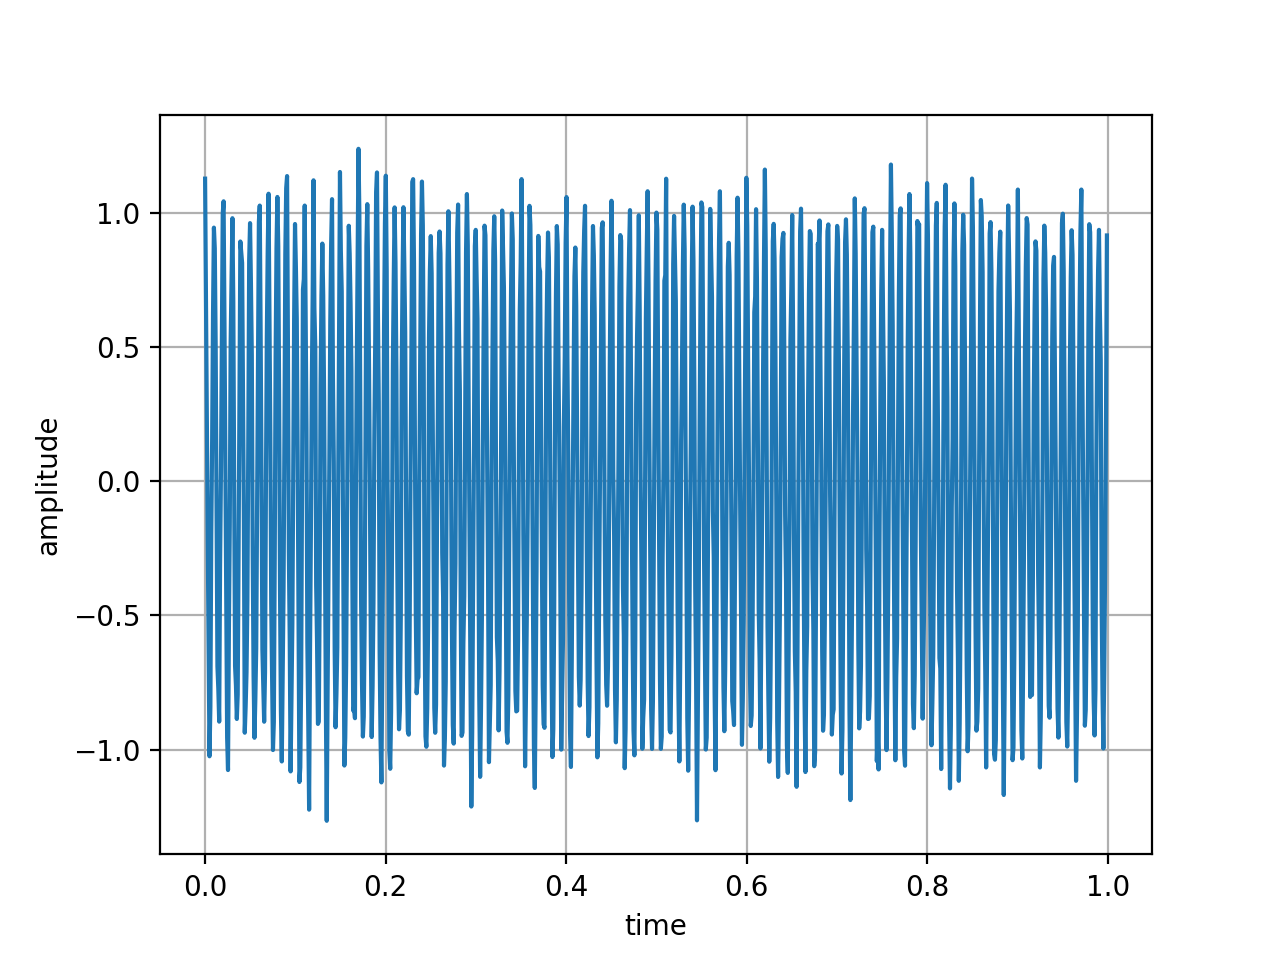

<IPython.core.display.Javascript object>


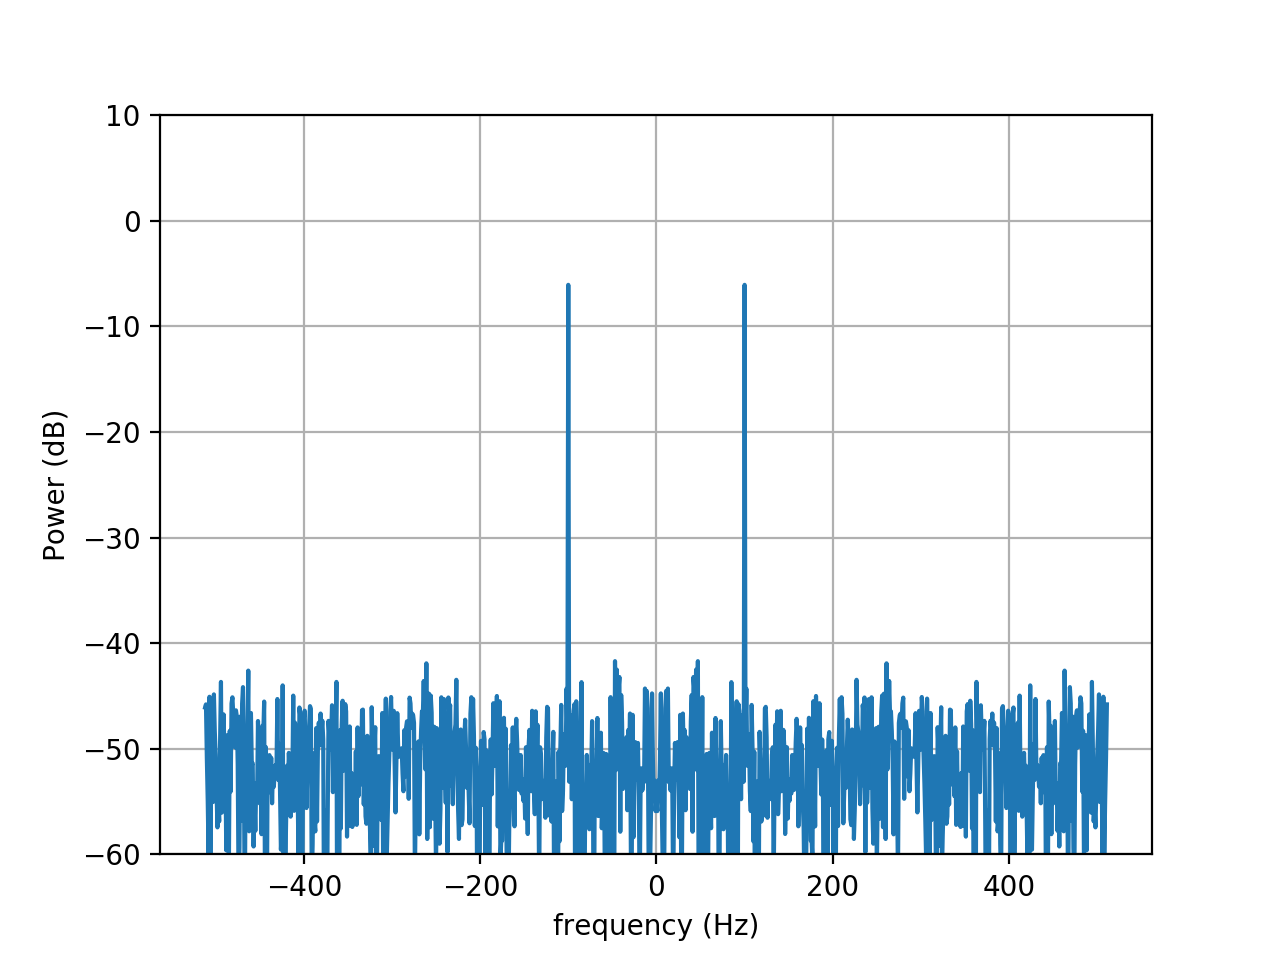

<IPython.core.display.Javascript object>


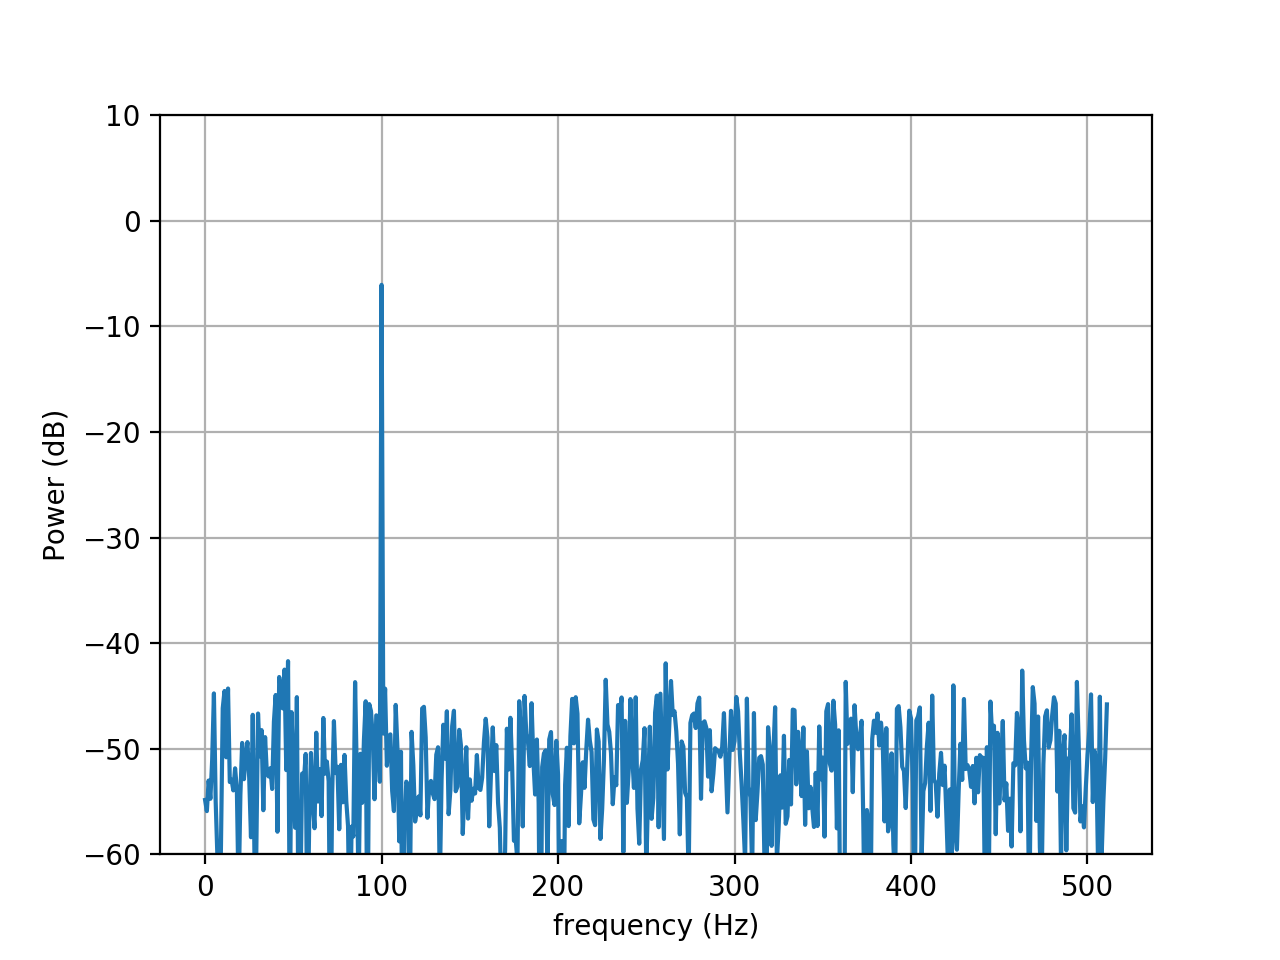

In [4]:
def noise(s, N, off = 0):
    return np.random.normal(loc=off, scale=s, size=N)

def example():
    # create a sine wa ve
    N = 2 ** 10 # samples
    t = np.arange(0,1,1/N) # time array
    dt = t[1] - t[0] # time step
    omega = 2 * np.pi * 100 # angular frequency
    y = np.cos(omega * t) # sine wave
    y += noise(.1,N) # add some white noise

    # plot it
    plt.figure()
    plt.plot(t,y.real)
    plt.ylabel("amplitude")
    plt.xlabel("time")
    plt.grid()
    plt.show()
    
    # Take an FFT
    s = fft.fftshift( fft.fft(y,N) / N ) # divide by N to normalize! see documentation. 
    S = np.abs(s) ** 2 # this is proportional to power 
    freq = fft.fftshift( fft.fftfreq(N, dt) ) # I'll explain the fft.fftshift later...
    PSD = 20 * np.log10(np.abs(s)) # power spectral density

    # plot all frequency components
    plt.figure()
    plt.plot(freq, PSD)
    plt.xlabel("frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.ylim(-60,10)
    plt.grid()
    
    # plot only positive frequencies
    plt.figure()
    plt.plot(freq[N//2:], PSD[N//2:])
    plt.xlabel("frequency (Hz)")
    plt.ylabel("Power (dB)")
    plt.ylim(-60,10)
    plt.grid()
    
    plt.show()
    return N, dt, freq

N, dt, freq = example()

# Sampling rate, sampling time, resolution
Let's consider how sample time, sample rate, and resolution are all related.

In this example, the sample rate was $1/dt = 1024$ kHz. Our sample time was 1 second. Therefore, the maximum resolvable frequency is determined by the Nyquist limit. In this cas $1/(2dt) = 512$ Hz. Because we sampled for 1 second, the frequency resolution should be 1 Hz. This is also typically referred to as resolution bandwidth. We can check all this numerically.

In [5]:
print(f"The number of samples was {N}")
print(f"The maximum frequency determined by Nyquist is {1/dt/2}")
print(f"The resolution bandwidth is {freq[1]-freq[0]} Hz")

The number of samples was 1024
The maximum frequency determined by Nyquist is 512.0
The resolution bandwidth is 1.0 Hz


# What's with the negative frequencies?
## sin${(\omega t)}$, cos${(\omega t)}$, and $e^{i\omega t}$

Remember that

&nbsp;&nbsp;&nbsp;&nbsp;$e^{i \omega t} = $ cos${(\omega t)} + j$ sin${(\omega t)}$

Of course you do...

This also means that

&nbsp;&nbsp;&nbsp;&nbsp;cos${(\omega t)} = \frac{1}{2} (e^{i \omega t} + e^{-i \omega t})$

So, trig functions are complex. Thus, negative frequencies are possible. In nature, there are no "negative" frequencies. However, there are situations where a phasor ( that is, something like $e^{i \omega t}$) can "spin" clockwise or counter clockwise relative to another phasor at a different frequency. This will be important when we discuss digitizers and I/Q sampling.

For now, I can show you how you can see the difference between a positive and negative frequency...But first, I'll write a general FFT function so I can save some typing.

### Note on the function fftshift
The FFT algorithm outputs the frequency components in an array that is $ [ 0\,, +freq\,,-freq]$. The fftshift functions just rearranges this to be $ [ -freq\,,0\,, +freq\,]$ to make plotting and visualization easier. 

<IPython.core.display.Javascript object>


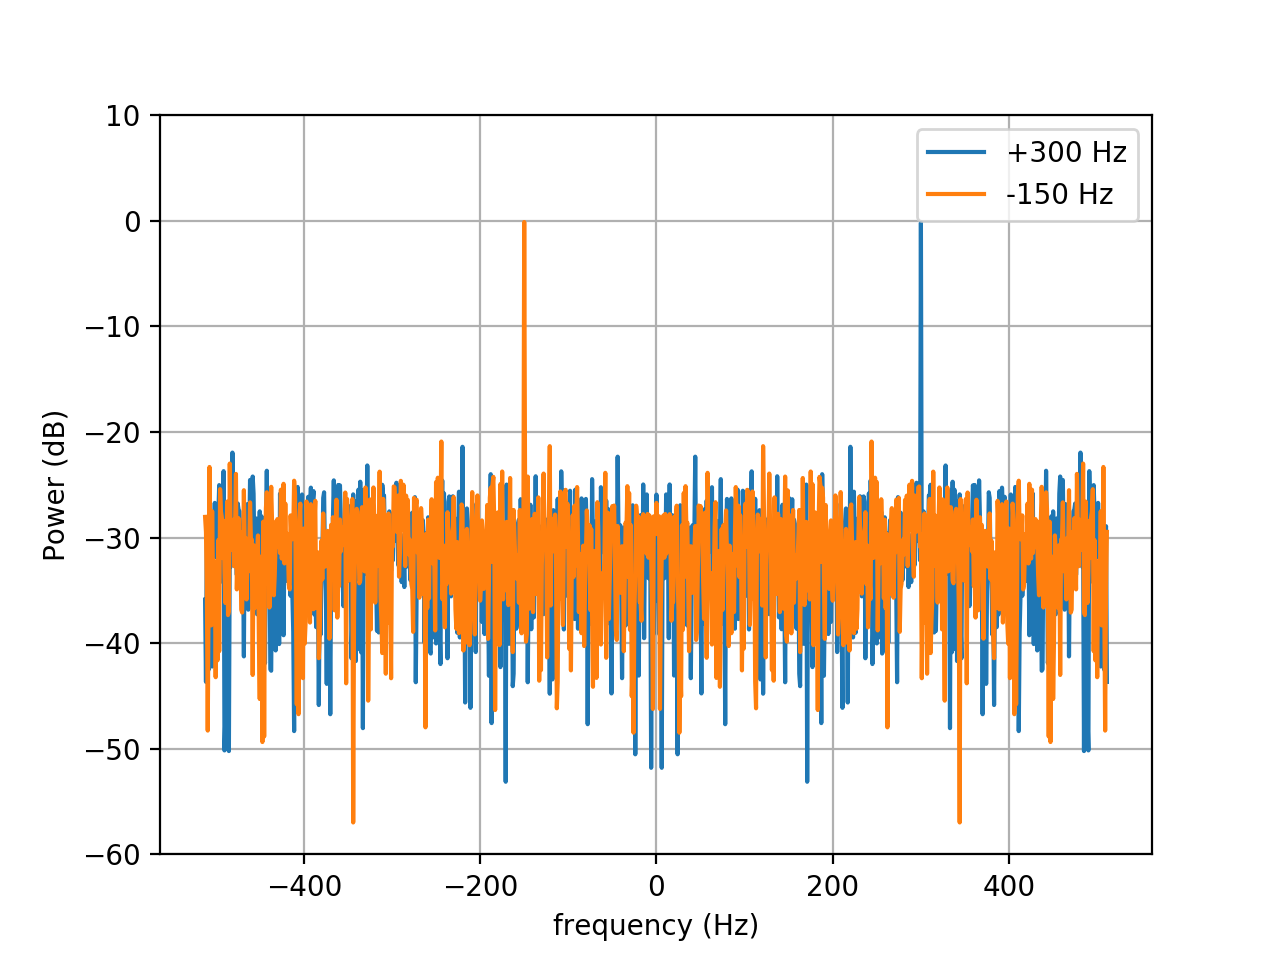

In [6]:
# make a simple FFT function
def FFT(t , y, N = 0):
    '''
    when you write a function put comments here. 
    call:
        FFT(t , y, N = 0)
    input:
        t: time array
        y: amplitude array with len(y) == len(t)
        N: FFT length, default is len(y)
    returns:
        freq: Fourier frequencies
        s: FFT amplitudes
        S: FFT Powers (linear)
        PSD: FFT powers (dB)
    '''
    if N == 0:
        N = len(t)
    
    dt = t[1] - t[0]
    s = fft.fftshift( fft.fft(y,N) / len(t) ) # divide by N to normalize! see documentation. 
    S = np.abs(s) ** 2 
    freq = fft.fftshift( fft.fftfreq(N, dt) ) # I'll explain the fft.fftshift later...
    PSD = 20 * np.log10(np.abs(s))
    return freq, s, S, PSD

# show a couple different signals
t = np.arange(0,1,1/2**10)
y1 = np.exp(2j * np.pi *  300* t) + noise(1, 2 ** 10)
y2 = np.exp(-2j * np.pi * 150 * t) + noise(1, 2 ** 10)

# take fft using our new function
freq1, s1, S1, PSD1 = FFT(t, y1)
freq2, s2, S2, PSD2 = FFT(t, y2)

#plot them
plt.figure()
plt.plot(freq1, PSD1, label = "+300 Hz")
plt.plot(freq2, PSD2, label = "-150 Hz")
plt.xlabel("frequency (Hz)")
plt.ylabel("Power (dB)")
plt.ylim(-60,10)
plt.legend()
plt.grid()
plt.show()

In [7]:
FFT?

# Getting the units correct
### Label your axes or I won't take you seriously. Seriously.
<img src="files/XKCD.png" width="800"/>

[and if you labeled your axes, I could tell you exactly how much](https://xkcd.com/833/)
### Normalization
As I previously discussed, it is important to read the documentation of the FFT you are using because there is no standard way to normalize them. This is important because, if you care about your data, then you definitely care about the y-axis when you plot it. So, getting that correct is super important.

Since we work in the RF world, I will show you how to get the y-axis correct. Let's assume we have a 1 Volt peak sine wave. Let's see if I can plot it correctly and get the correct power reading for various sampling times. The amount of sampling time should **NOT** change the power reading. 


<IPython.core.display.Javascript object>


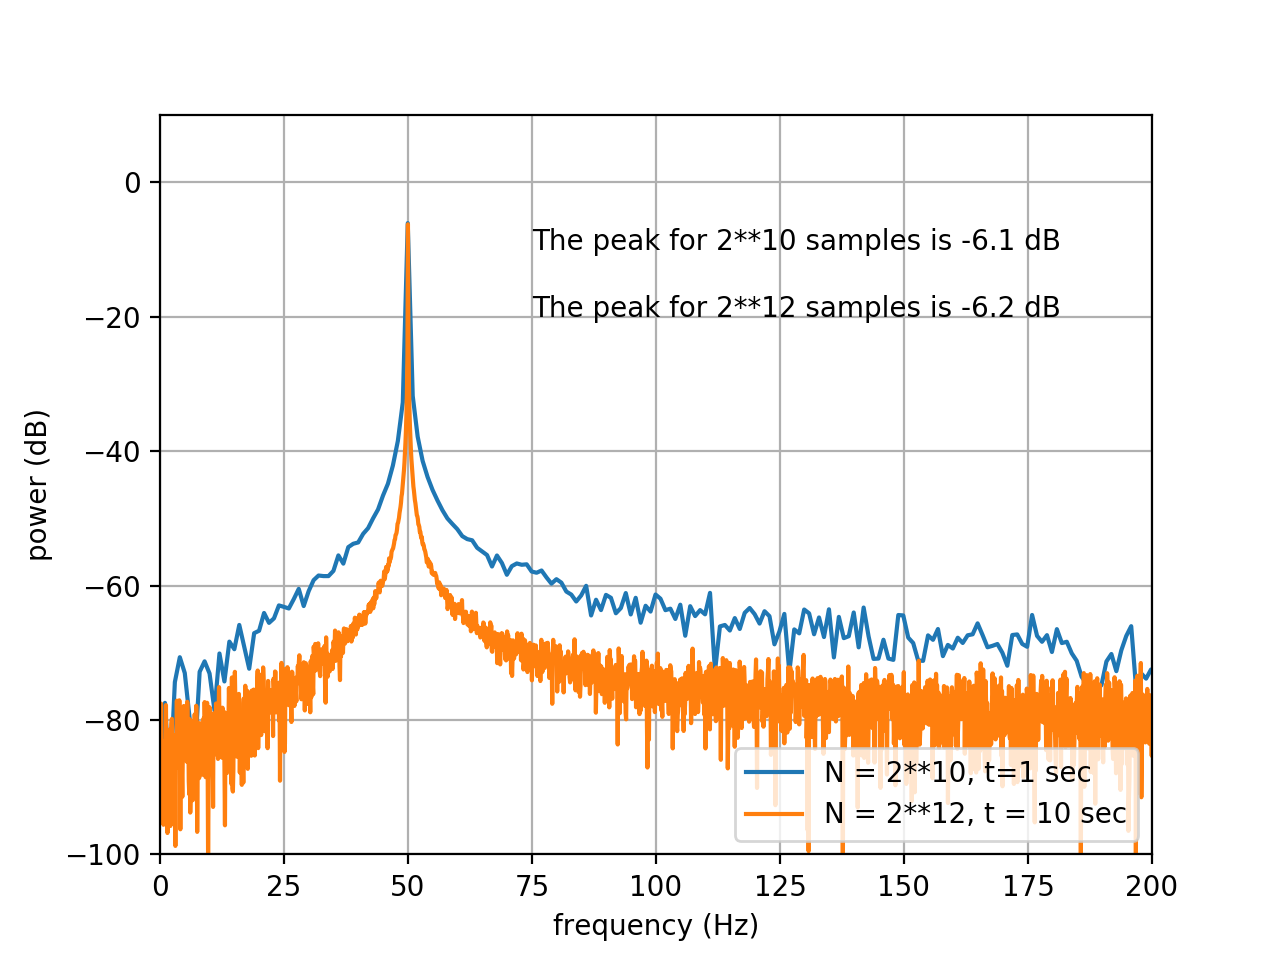

In [8]:
def wave(f, tmax, N = 2**10):
    '''
    Call:
       t, y = wave(f, tmax, N = 2**10)
    Input:
        f: input frequency in Hz
        tmax: max time in seconds
    Output:
        t: time array
        y: the sine wave
    '''
    t = np.linspace(0,tmax,N)
    omega = 2 * np.pi * f
    return t, np.sin(omega * t) 

t1, y1 = wave(50,1, N=2**10)
t2, y2 = wave(50,10, N=2**12)

freq1, s1, S1, PSD1 = FFT(t1, y1+noise(.005, len(y1)))
freq2, s2, S2, PSD2 = FFT(t2, y2+noise(.005, len(y2)))

plt.figure()
plt.plot(freq1, 10*np.log10(S1), label = "N = 2**10, t=1 sec") 
plt.plot(freq2, 10*np.log10(S2), label = "N = 2**12, t = 10 sec")
plt.ylim(-100,10)
plt.xlim(0,200)
plt.xlabel("frequency (Hz)")
plt.ylabel("power (dB)")
plt.text(75,-10, f"The peak for 2**10 samples is {np.round(max(10*np.log10(S1)),1)} dB")
plt.text(75,-20, f"The peak for 2**12 samples is {np.round(max(10*np.log10(S2)),1)} dB")
plt.legend(loc = "lower right")
plt.grid()
plt.show()

OK, but so far, I have only converted the power to dB. I don't have any real units yet.

So, since we usually use dBm, I'll show you how to conver to that...

dBm is a power scale referenced so that 1 mW = 0 dBm. For RF systems, the power is measured by $ Power =  \frac{V_{rms}^2}{R}$, or in units of mW $ Power [mW] = 1\times10^{3}  \frac{V_{rms}^2}{R}$.

So, now for some useful relations:

&nbsp;&nbsp;&nbsp;&nbsp;$V_{rms} = \frac{|V_{p}|}{\sqrt(2)}$

&nbsp;&nbsp;&nbsp;&nbsp;$dBm \rightarrow 10\cdot log_{10}\left(  \frac{V_{rms}^2 10^3}{50}  \right) $

Also, remember that the $|a|^2\propto$ power where $a$ are our FFT amplitudes (the outputs of the FFT). So we just need to factor that in. Also, rememberthat $a$ is an amplitude, not a peak-peak value. 

For the PSD that is calculated in the FFT function I previously defined, I just need to scale it by $10\cdot log_{10}\left( \frac{1000}{2\times50}\right) = 10$

<IPython.core.display.Javascript object>


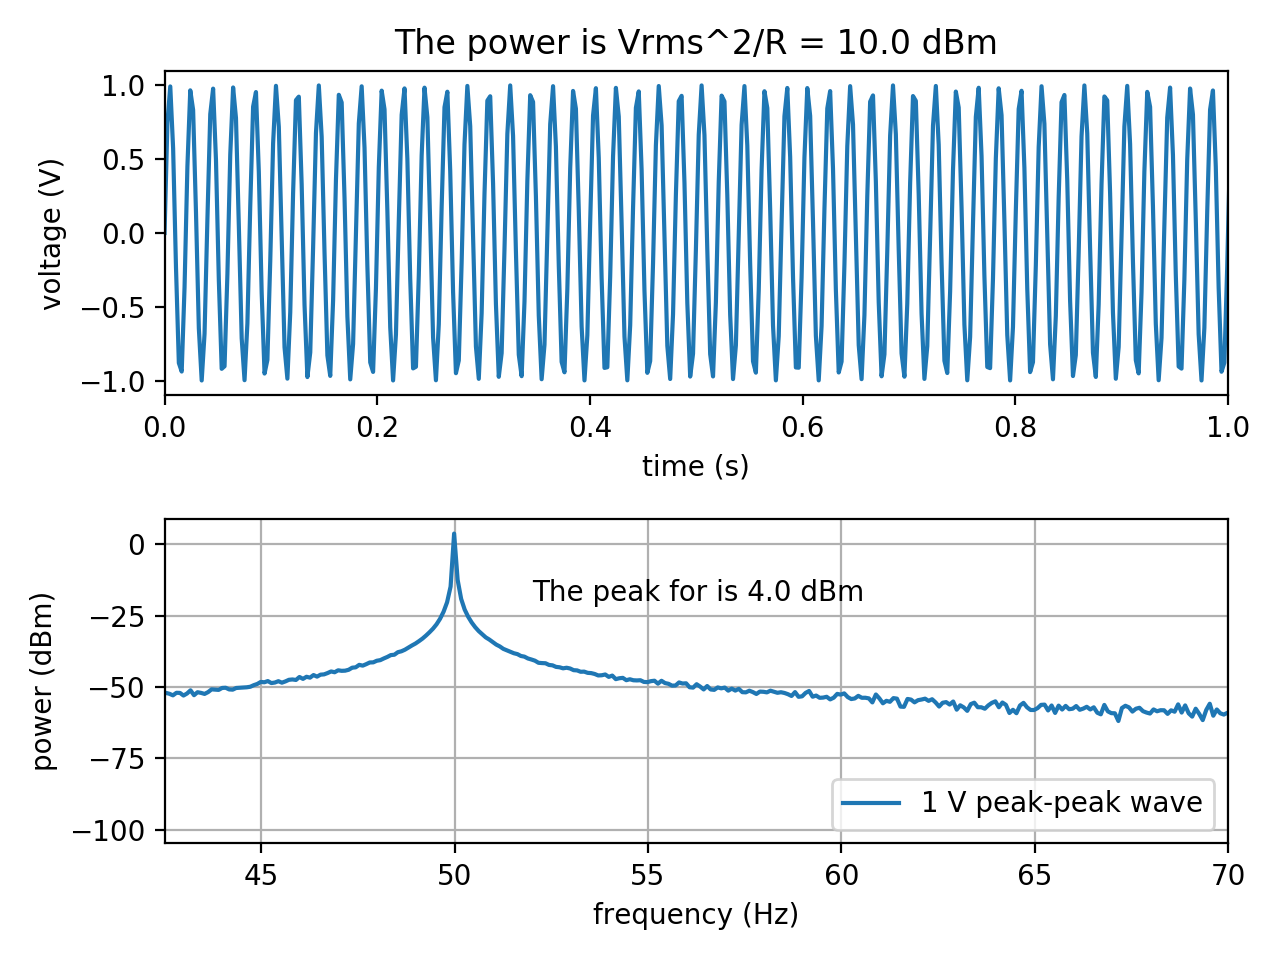

In [9]:
# make a wave
t1, y1 = wave(50,11, N=2**12)
# FFT it
freq1, s1, S1, PSD1 = FFT(t1, y1+noise(.005, len(y1)))
# calc rms value of time domain signal
Vrms = np.sqrt(np.mean(np.abs(y1)**2))

def dBm(x):
    '''
    takes the FFT PSD and converts to dBm.
    Call:
        xx = dBm(x)
    input:
        x: a float
    output
        xx: a float
    '''
    return 10 + x

# plot stuff
_, ax = plt.subplots(2)
# time domain
ax[0].set_title(f"The power is Vrms^2/R = {np.round(30+10*np.log10(Vrms**2/50),1)} dBm")
ax[0].plot(t1, y1)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("voltage (V)")
ax[0].set_xlim(0,1)
#frequency domain
ax[1].plot(freq1, dBm(PSD1), label = "1 V peak-peak wave")
ax[1].set_xlim(42.5,70)
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dBm)")
#formatting
plt.text(52,-20, f"The peak for is {np.round(max(dBm(PSD1)),0)} dBm")
plt.legend(loc = "lower right")
plt.grid()
plt.tight_layout()
plt.show()

# What?! Off by 6 dB. 

The reason for the factor of 2 is because how the FFT works and how we defined our input. Remember that:  $a\,cos{(\omega t)} = \frac{a}{2} (e^{i \omega t} + e^{-i \omega t})$. So, a cosine is made up of a negative and positive phasor. If we want to accurately recover "$a$", we need to measure the power in the positive and negative rotating phasor. Above, I only plotted the positive frequency compenents. If I repeat the process above and show the full FFT output, the factor of 2 in amplitude (or 6 dB in power missing) is easily explained. 

So, how do we deal with this practically? One of a few ways. You can remember there is a factor of 2 floating around (in amplitude) when taking FFTs of real functions (and not complex I/Q data, more on this later). Or, emperically determine how to normalize. IE, FFT something with a known answer and check that against the output. Scale appropriately. Another option is to add the amplitudes of the negative and positive frequency components together if you only want to look at the one-sided PSD. Or, multiply by 2 on the positive frequency side if you know your functions are symmetric about 0 Hz. 

If this sounds fishy to you, I'll plot a sin and an exp on the same chart and you'll see the amplitude difference.

Another thing to consider with a 1/N verus 2/N scaling is the function $ e^{i\omega t}$ should normalize to one in the integral. Its output is also a delta function. Don't believe me? Go to wikipedia and look up the [Dirac Delta function](https://en.wikipedia.org/wiki/Dirac_delta_function#Fourier_transform) with regards to FFTs. The straightforward 1/N scaling also the normalization scheme that satisfies Parseval's theorem (more on that below). 

<IPython.core.display.Javascript object>


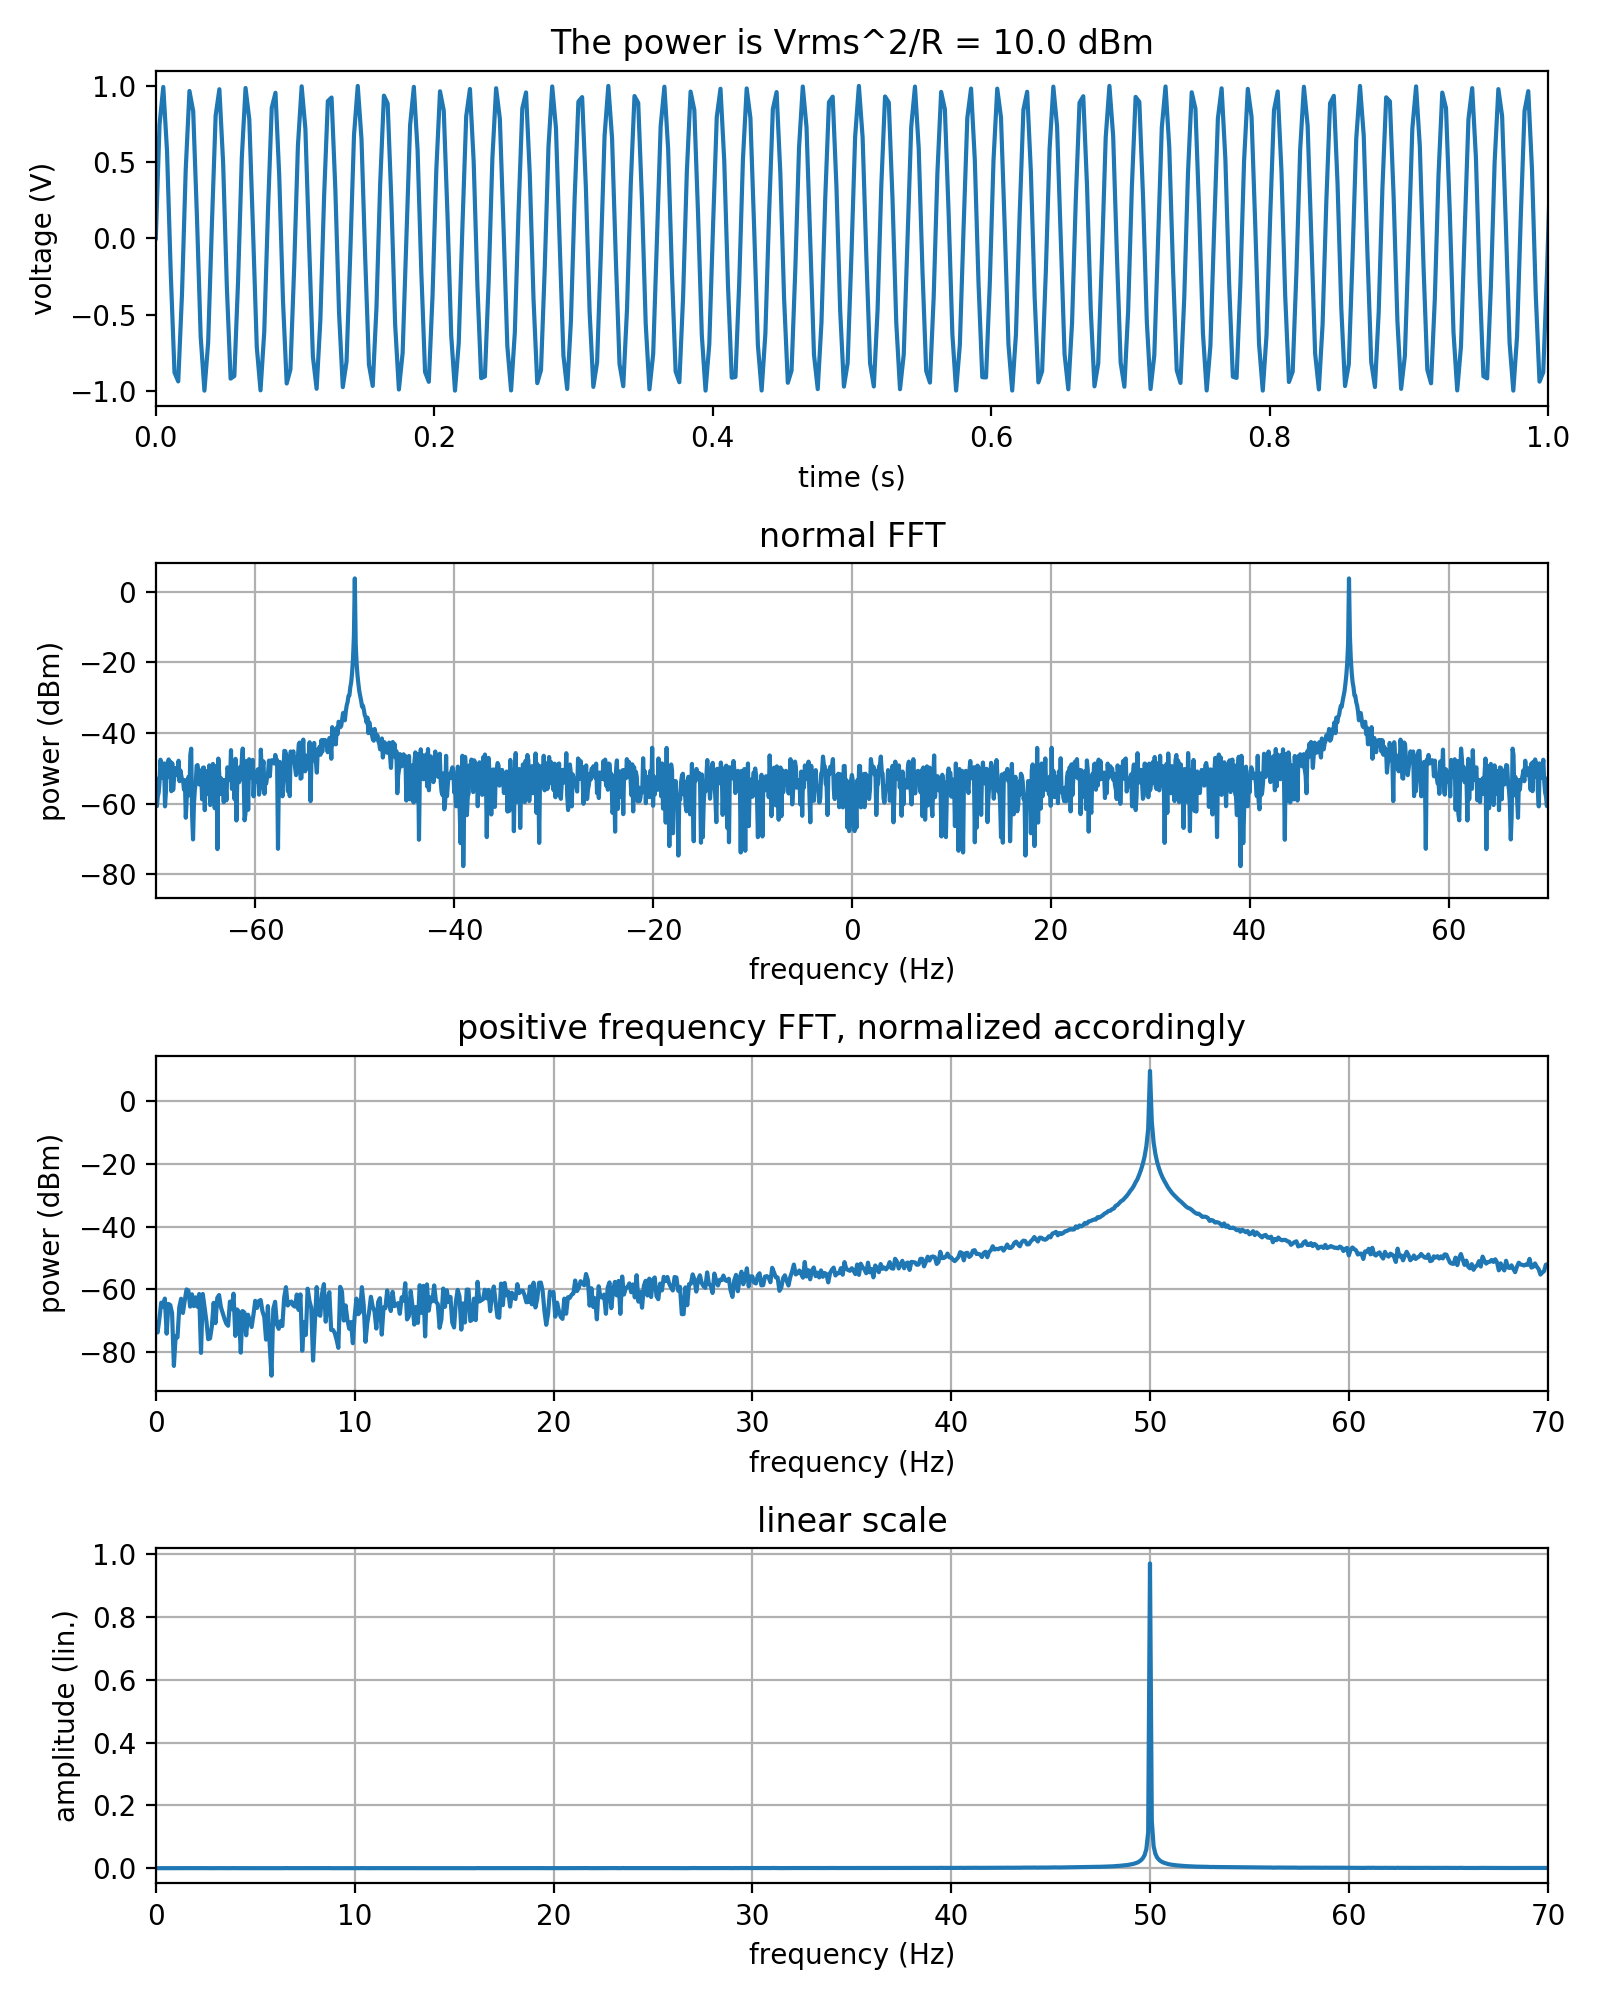

In [10]:
# make a wave
t1, y1 = wave(50,11, N=2**12)

# fft it
freq1, s1, S1, PSD1 = FFT(t1, y1+noise(.05, len(y1)))
Vrms = np.sqrt(np.mean(np.abs(y1)**2))

# an FFT function for real functions, 2/N scaling
def rFFT(t , y, N = 0):
    '''
    This FFT is normalized assuming real valued functions. 
    call:
        f, s, S, PSD = rFFT(t , y, N = 0)
    input:
        t: time array
        y: amplitude array with len(y) == len(t)
        N: FFT length, default is len(y)
    returns:
        freq: Fourier frequencies
        s: FFT amplitudes
        S: FFT Powers (linear)
        PSD: FFT powers (dB)
    '''
    if N == 0:
        N = len(y)
    
    dt = t[1] - t[0]
    s =  fft.fftshift(fft.fft(y,N) * 2 / len(t))  # divide by N to normalize! see documentation. 
    S = np.abs(s) ** 2  
    freq = fft.fftshift(fft.fftfreq(N, dt))  # I'll explain the fft.fftshift later...
    PSD = 20 * np.log10(np.abs(s))
    return freq[N//2:], s[N//2:], S[N//2:], PSD[N//2:]

freq2, s2, S2, PSD2 = rFFT(t1, y1+noise(.005, len(y1)))

_, ax = plt.subplots(4, figsize=(8,10))
ax[0].set_title(f"The power is Vrms^2/R = {np.round(30+10*np.log10(Vrms**2/50),1)} dBm")
ax[0].plot(t1, y1)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("voltage (V)")
ax[0].set_xlim(0,1)

ax[1].plot(freq1, dBm(PSD1), label = "1 V peak-peak wave")
ax[1].set_xlim(-70,70)
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dBm)")
ax[1].set_title("normal FFT")
ax[1].grid()

ax[2].plot(freq2, dBm(PSD2), label = "1 V peak-peak wave")
plt.text(20,-20, f"The peak for is {np.round(max(dBm(PSD2)),0)} dBm")
ax[2].set_xlim(0,70)
ax[2].set_xlabel("frequency (Hz)")
ax[2].set_ylabel("power (dBm)")
ax[2].set_title("positive frequency FFT, normalized accordingly")
ax[2].grid()


ax[3].plot(freq2, np.abs(s2), label = "1 V peak-peak wave")
ax[3].set_xlim(0,70)
ax[3].set_xlabel("frequency (Hz)")
ax[3].set_ylabel("amplitude (lin.)")
ax[3].set_title("linear scale")
ax[3].grid()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


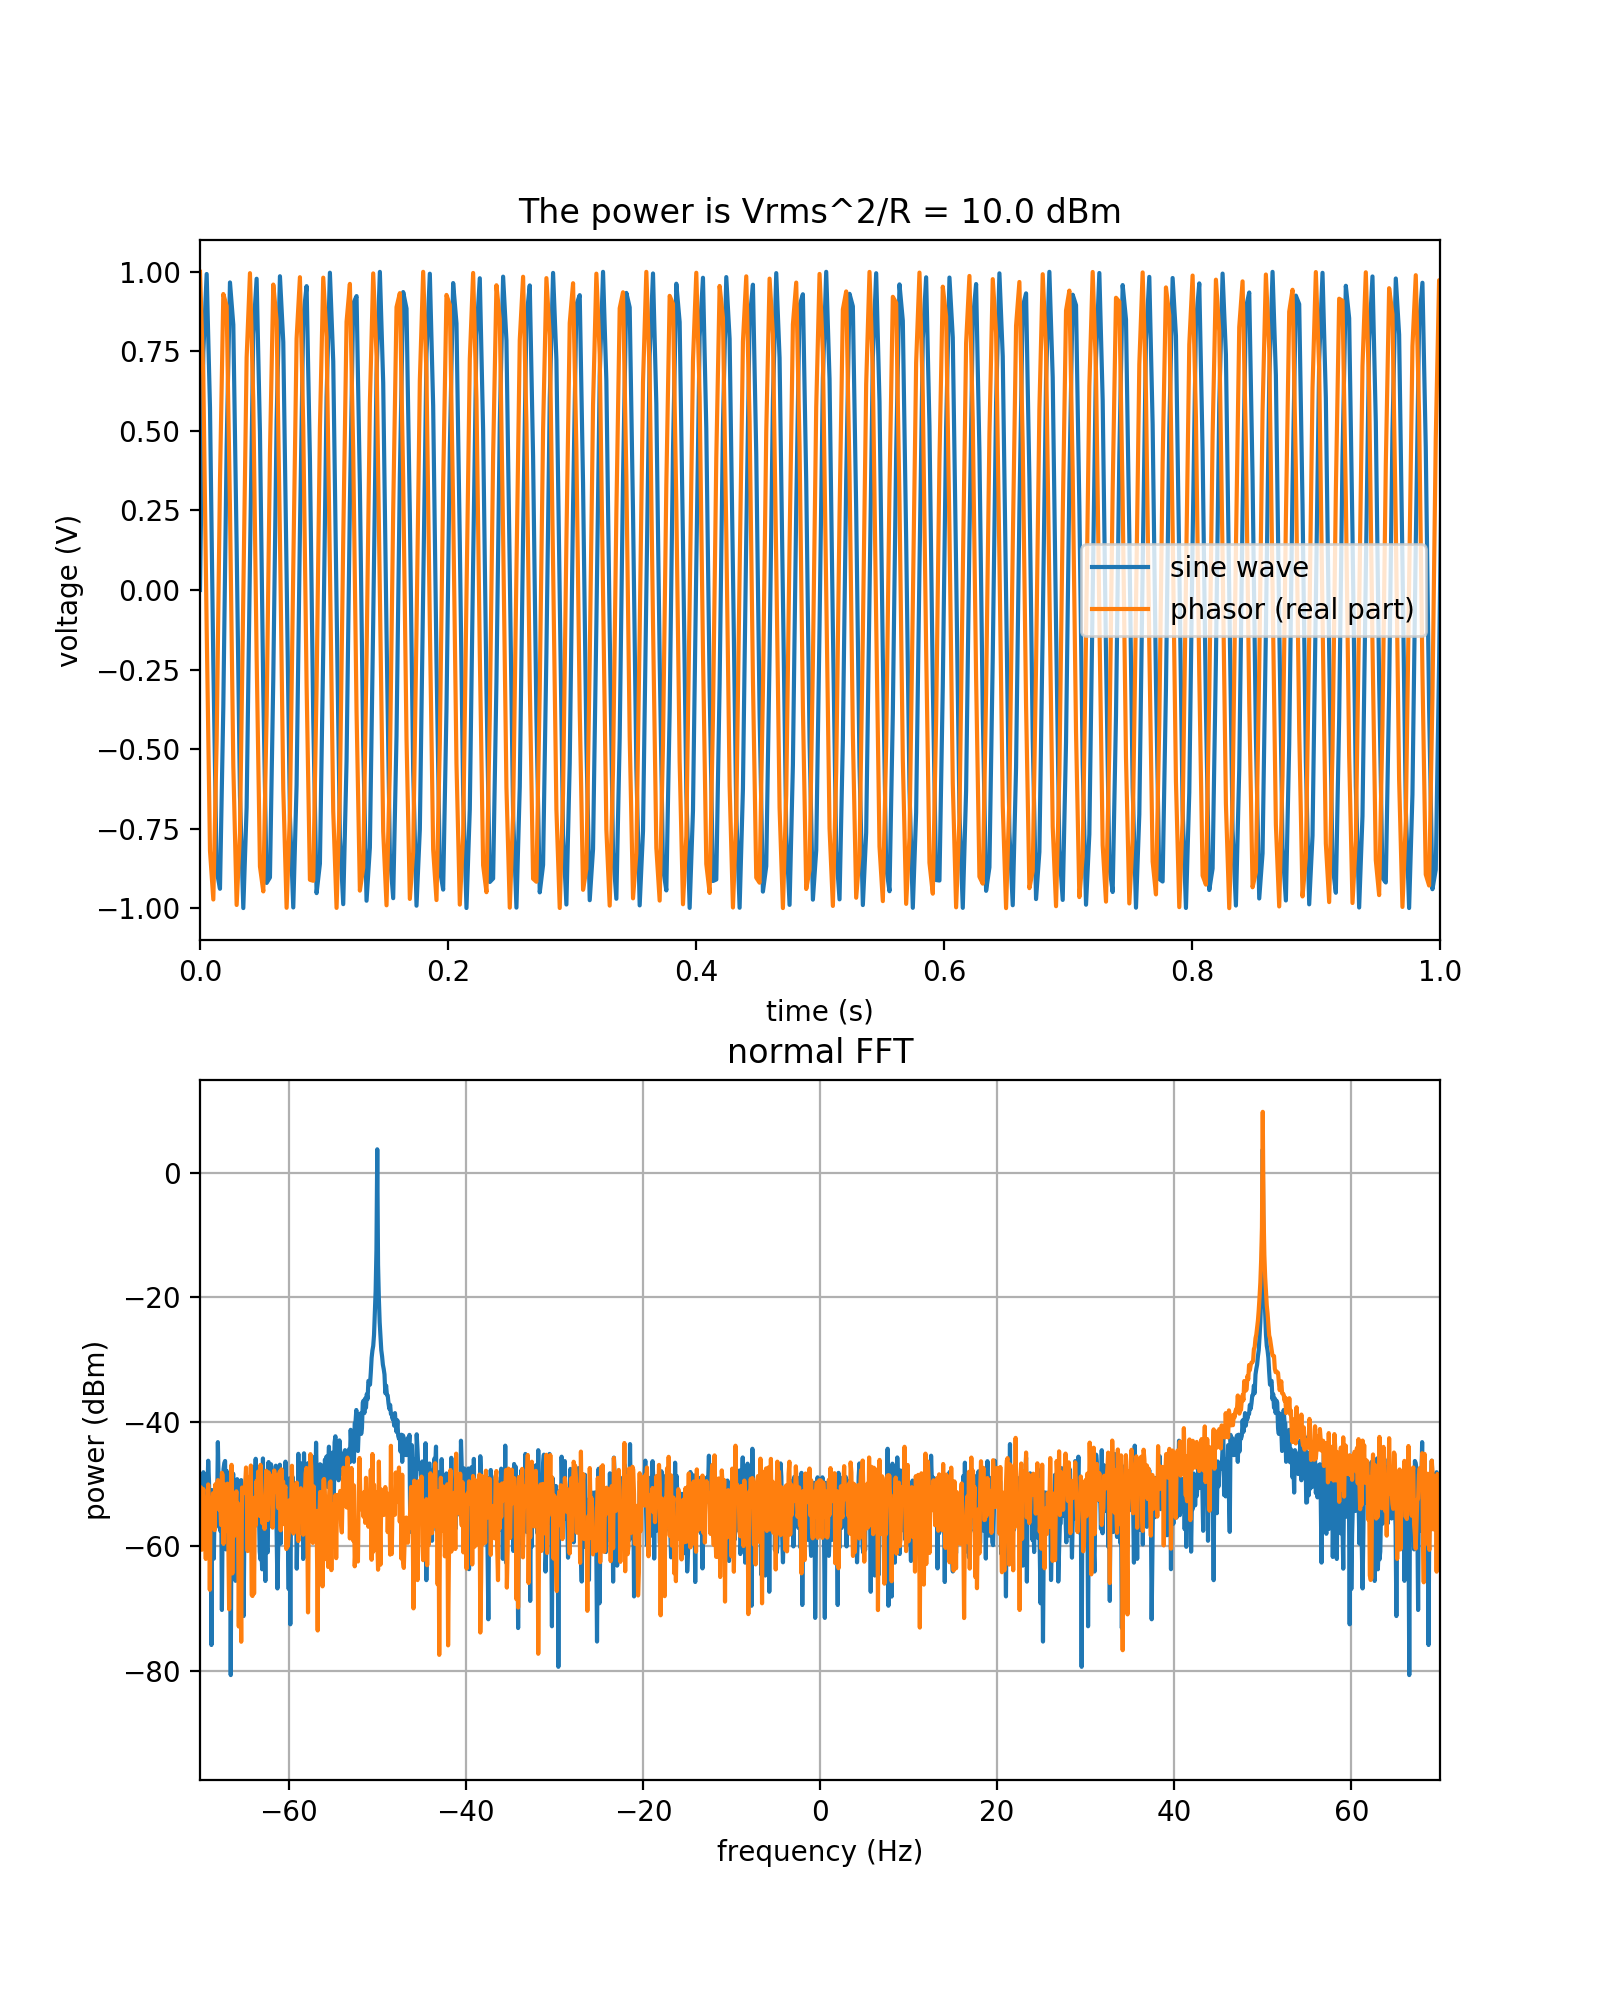

In [11]:
# sine wave
t1, y1 = wave(50,11, N=2**12)
# fft
freq1, s1, S1, PSD1 = FFT(t1, y1+noise(.05, len(y1)))
# phasor
y2 = np.exp(2j * np.pi * 50 * t1)
# fft
freq2, s2, S2, PSD2 = FFT(t1, y2+noise(.05, len(y2)))
# plots
_, ax = plt.subplots(2, figsize=(8,10))
ax[0].set_title(f"The power is Vrms^2/R = {np.round(30+10*np.log10(Vrms**2/50),1)} dBm")
ax[0].plot(t1, y1, label = "sine wave")
ax[0].plot(t1, y2.real, label = "phasor (real part)")
ax[0].legend()
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("voltage (V)")
ax[0].set_xlim(0,1)

ax[1].plot(freq1, dBm(PSD1), label = "sine wave")
ax[1].plot(freq1, dBm(PSD2), label = "phasor")
ax[1].set_xlim(-70,70)
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dBm)")
ax[1].set_title("normal FFT")
ax[1].grid()

### for the nerds...
Or, a third, super nerdy way to check normalization. Use [Parsevals theorem](https://en.wikipedia.org/wiki/Parseval%27s_theorem)

**Parseval's Theorem**:

The sum of the squares of the signal amplitudes == the sum of the squares of FT amplitudes.

This is another way of stating energy is conserved. Or, alternatively phrased, the FFT is a unitary transform. 

In [12]:
# checking parseval's theorem.
t1, y1 = wave(50,11, N=2**12)
freq1, s1, S1, PSD1 = FFT(t1, y1)

print(f"The sum of the square of the signal are {np.round(1/2**12*np.sum(np.abs(y1)**2),2)}")
print(f"The sum of the square of the FFT amplitudes are {np.round(np.sum(S1),2)}")


The sum of the square of the signal are 0.5
The sum of the square of the FFT amplitudes are 0.5


<img src="files/thumbsup.gif">

# One more note on the y-axis: Bandwidth normalized units
I'm sure you have all seen power reported as dBm or dBm/Hz. Which one is correct?

Well, both if used correctly. Imagine you have a very narrowband signal such that all the energy falls into a single FFT bin. Then, dBm and dBm/Hz should yield the same power result, but the noise floor might be different. However, if you have a broadband signal and you ask "What is its total power?", it is not sufficient to just read off the peak. There, you need to know the PSD in bandwidth normalized units so you can integrate up the power.

You will definitely encounter this when discussing thermal noise. Thermal noise is often quoted as -174 dBm/Hz. So, for a 1 Hz bandwidth (or 1 second integration time), the total noise is -174 dBm. How about at 1 MHz RBW? Then you just multiply by the bandwidth and you can get the results. But, since dB is logarithmic, you add when you multiply and subtract when you divide. 1 MHz -> 60 dB. So the total noise power in a 1 MHz RBW is -174 dBm + 60 dBm = -114 dBm. 

<IPython.core.display.Javascript object>


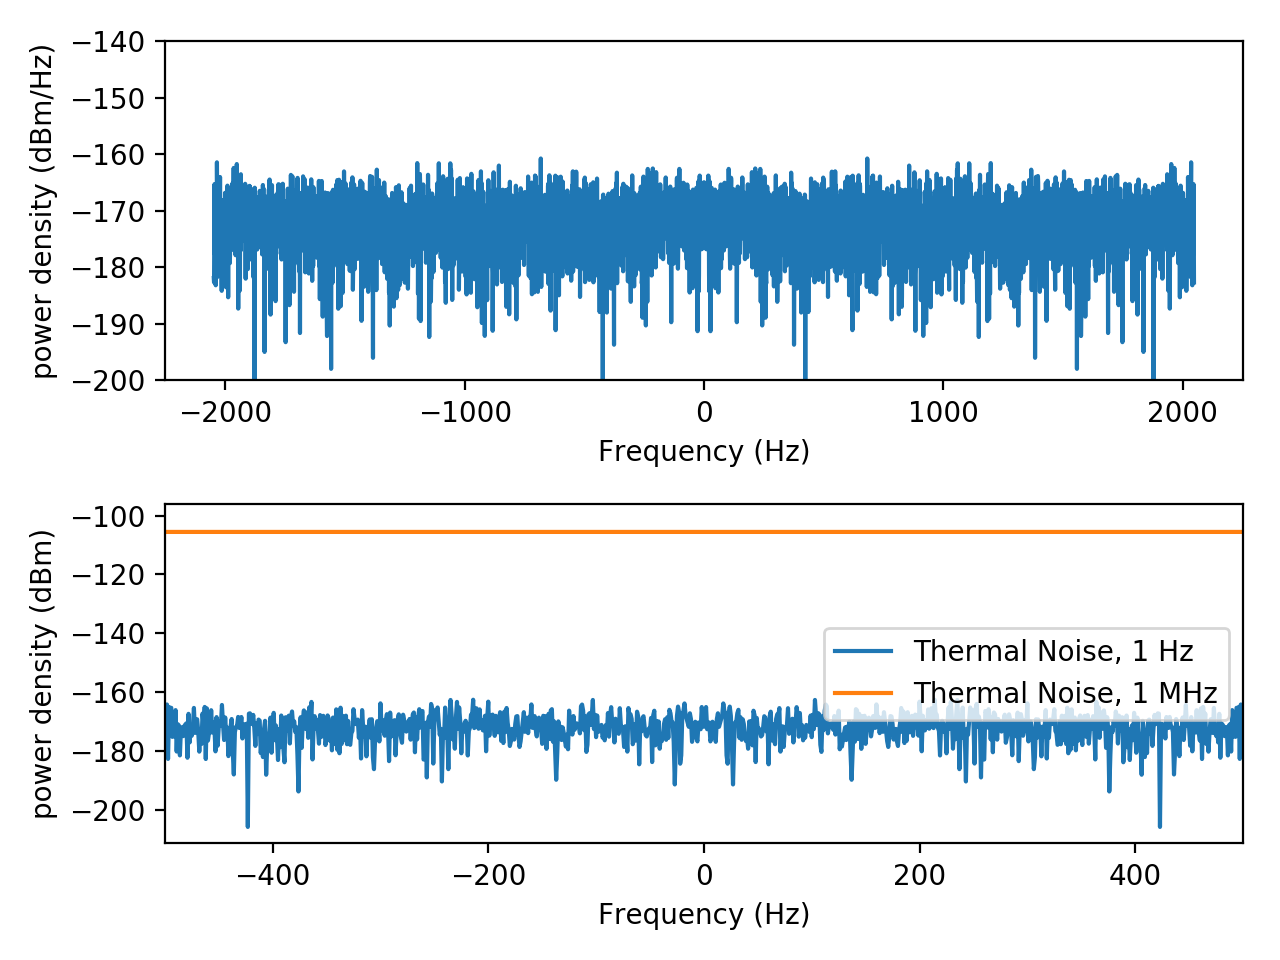

In [13]:
n1 = noise(10**((-174+30)/20), 2**12)
t1 = np.arange(0,1,1/2**12)
freq1, s1, S1, PSD1 = FFT(t1, n1)
_, ax = plt.subplots(2)
ax[0].plot(freq1, dBm(PSD1), label = "Thermal Noise")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_ylabel("power density (dBm/Hz)")
ax[0].set_ylim(-200,-140)

n2 = noise(10**((-174+30)/20), 2**12)
t2 = np.arange(0,1,1/2**12) * 1e-6
freq2, s2, S2, PSD2 = FFT(t2, n2)
PSD2_bw =PSD2 +  10*np.log10(freq2[1] - freq2[0]) # for bandwidth normalization
ax[1].plot(freq1, dBm(PSD1), label = "Thermal Noise, 1 Hz")
ax[1].plot(freq2, dBm(PSD2_bw), label = "Thermal Noise, 1 MHz")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_ylabel("power density (dBm)")
ax[1].set_xlim(-500,500)
ax[1].legend(loc = "center right")
plt.tight_layout()

# If you can't do FFT, then at least think FFT
Here are some useful properties of FFTs that everyone should have a handle on. I'll list them and show examples:
- The FT of a gaussian (bell curve) is a gaussian.
- The FT of a pulse that is short in the time domain is broad in the frequency domain.
- The FT of something long/broad in the time domain is narrow in the frequency domain.
- The FT of a box is a sinc.
- The FT of periodic signals with sharp features usually leads to harmonics.
- Sharp feature in the time/frequency domain lead to a lot of components in the frequency/time domain.
- You can generalize to more than one dimension. IE, take FFTs of images.  

<IPython.core.display.Javascript object>


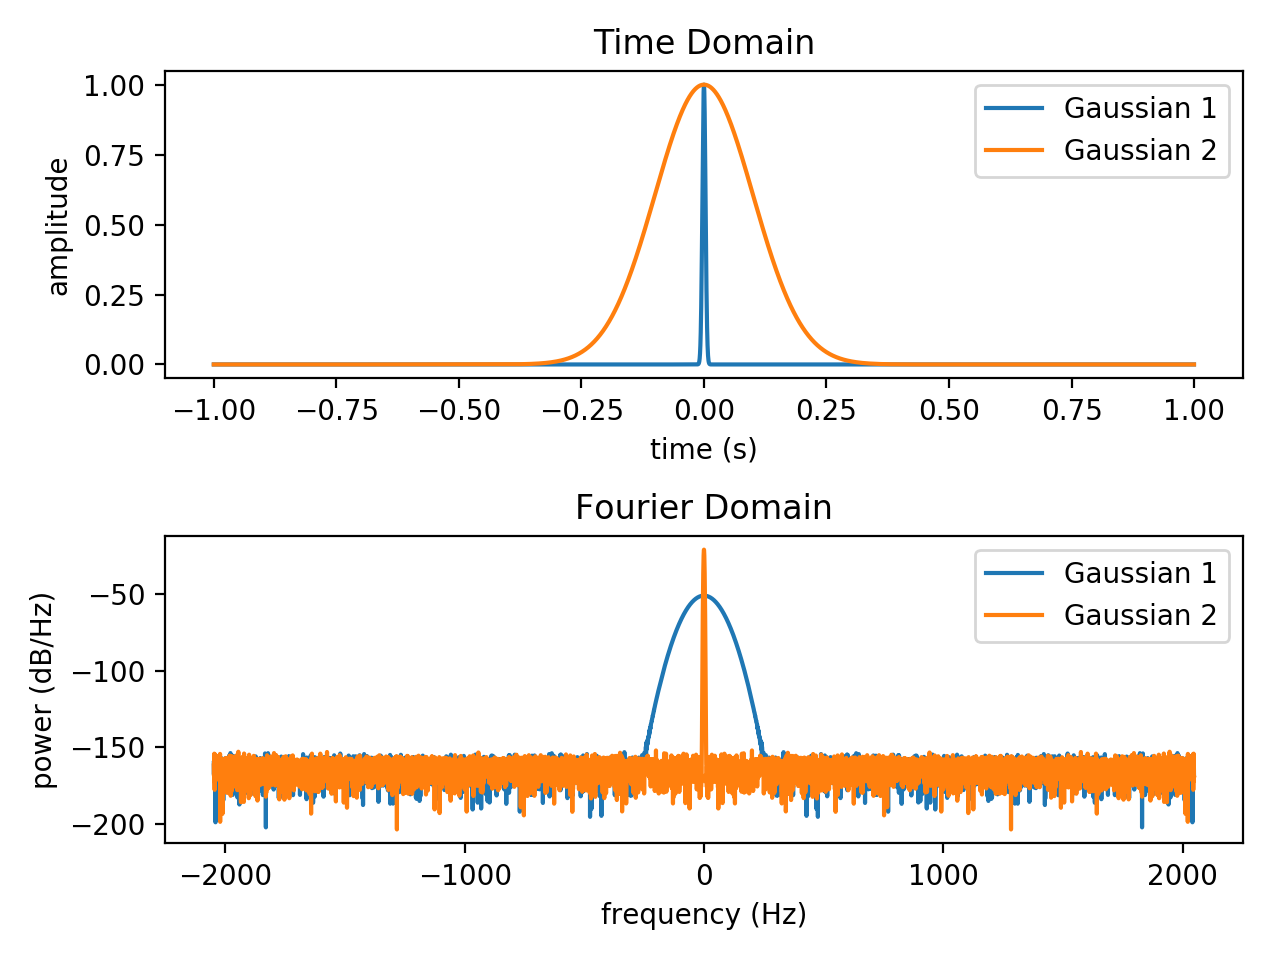

In [14]:
## Gaussians and pulses
N = 2 ** 12
t = np.arange(-1,1,1/N)

gaussian1 = np.exp(-t**2/.00002)+noise(1e-6,len(t))
gaussian2 = np.exp(-t**2/.02)+noise(1e-6,len(t))
f1,s1,S1,PSD1 = FFT(t,gaussian1)
f2,s2,S2,PSD2 = FFT(t,gaussian2)
RBW = f1[1] - f1[0]
_,ax = plt.subplots(2)
ax[0].plot(t, gaussian1, label = "Gaussian 1")
ax[0].plot(t, gaussian2, label = "Gaussian 2")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")
ax[0].legend()
ax[1].plot(f1, PSD1+10*np.log10(RBW), label = "Gaussian 1")
ax[1].plot(f2, PSD2+10*np.log10(RBW), label = "Gaussian 2")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dB/Hz)")
ax[1].set_title("Fourier Domain")
ax[1].legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


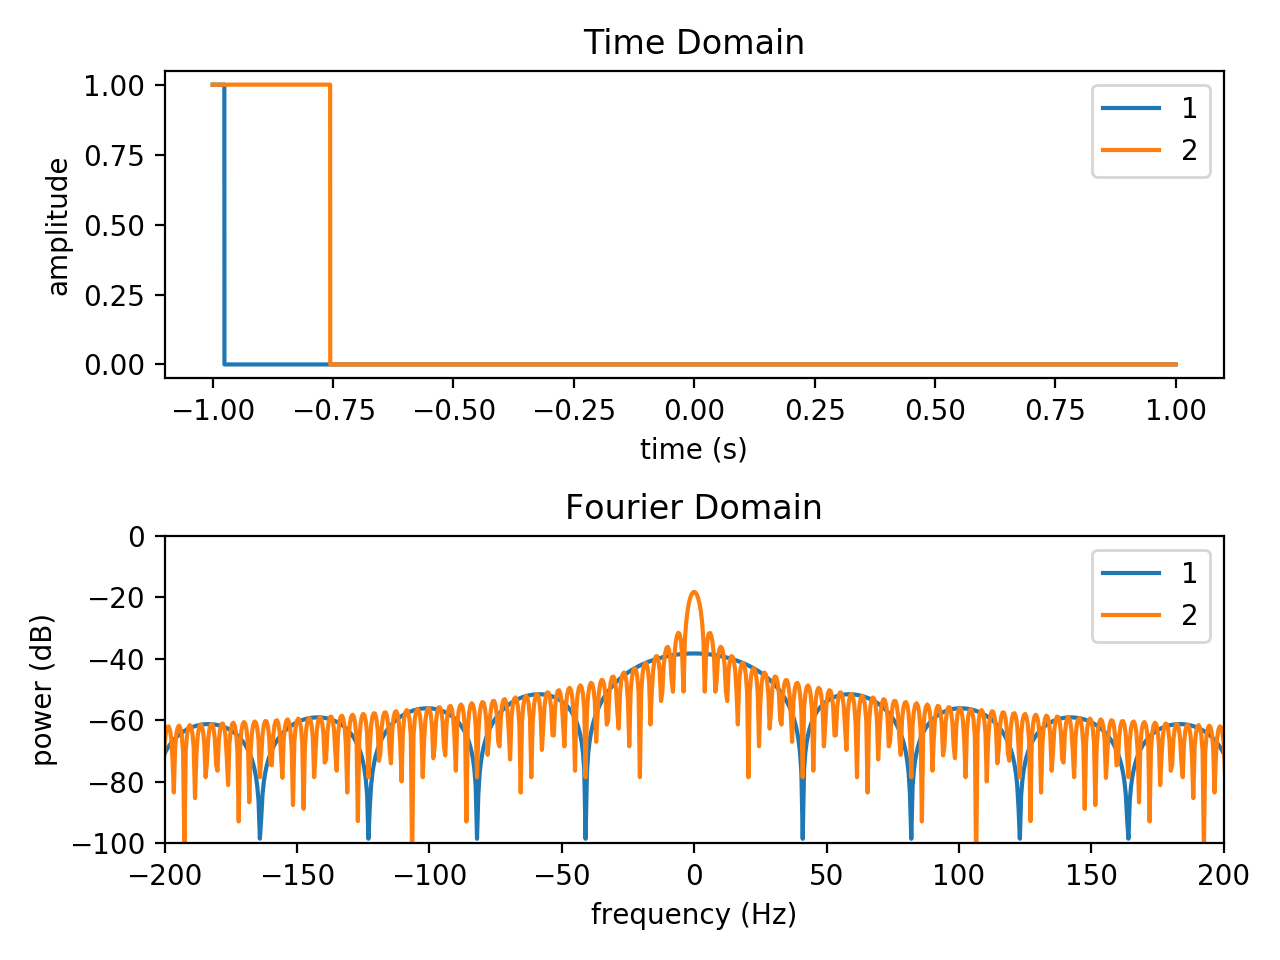

In [15]:
## squares
N = 2 ** 12
t = np.arange(-1,1,1/N)
g1 = np.zeros_like(t)+noise(1e-6,len(t))
g1[0:100] = np.ones(100)

g2 = np.zeros_like(t)+noise(1e-6,len(t))
g2[0:1000] = np.ones(1000)

f1,s1,S1,PSD1 = FFT(t,g1)
f2,s2,S2,PSD2 = FFT(t,g2)

_,ax = plt.subplots(2)
ax[0].plot(t, g1, label = "1")
ax[0].plot(t, g2, label = "2")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")
ax[0].legend()
ax[1].plot(f1, PSD1, label = "1")
ax[1].plot(f2, PSD2, label = "2")

ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dB)")
ax[1].set_title("Fourier Domain")
ax[1].legend()
ax[1].set_xlim(-200,200)
ax[1].set_ylim(-100,0)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


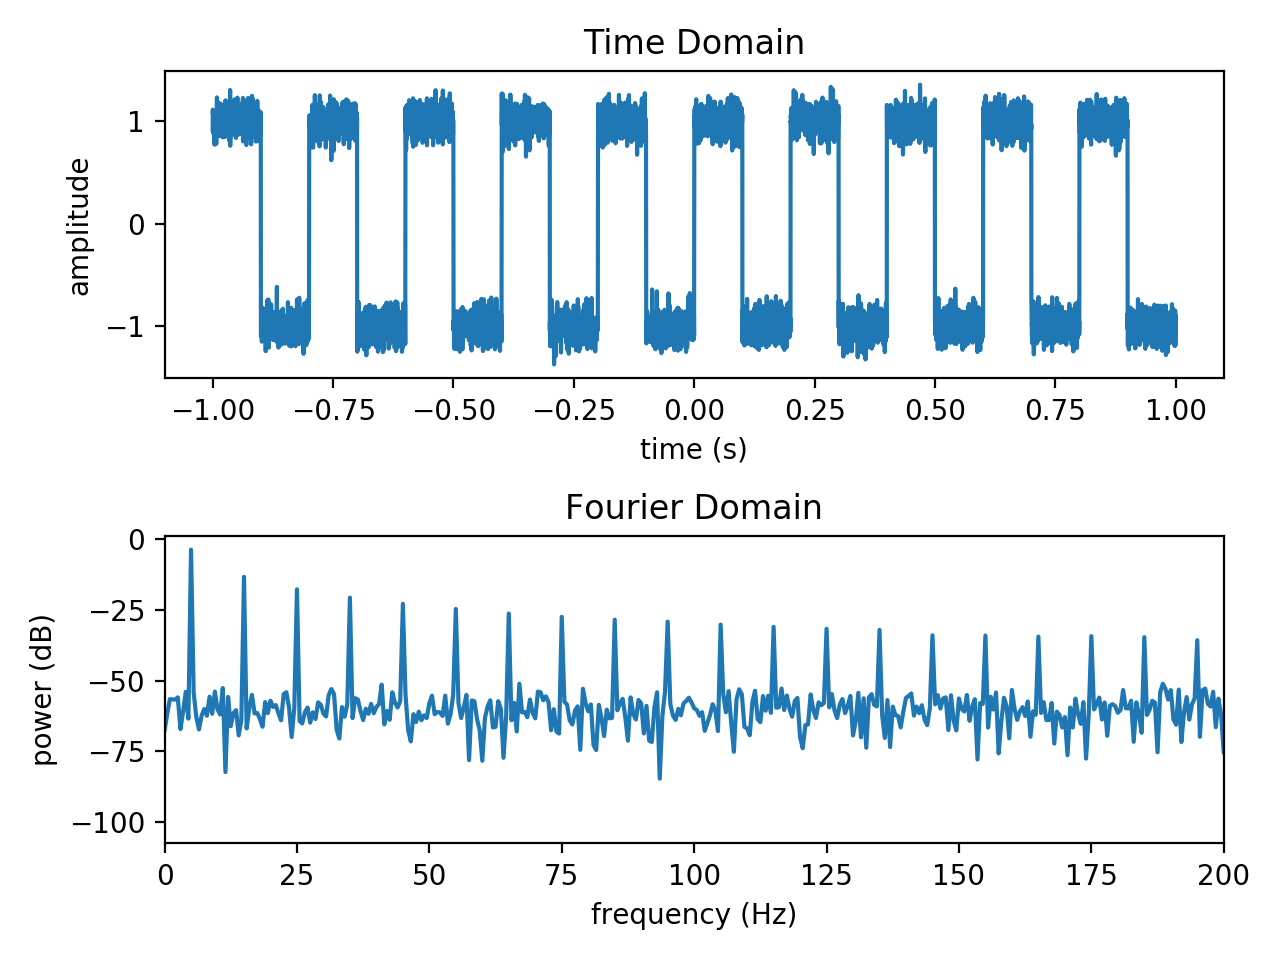

In [16]:
from scipy.signal import square
## square wave
N = 2 ** 12
t = np.arange(-1,1,1/N)
g1 = square(2*np.pi*5*t,.5) + noise(.1,len(t)) 
f1,s1,S1,PSD1 = FFT(t,g1)

_,ax = plt.subplots(2)
ax[0].plot(t, g1, label = "1")

ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")


ax[1].plot(f1, PSD1, label = "1")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dB)")
ax[1].set_title("Fourier Domain")
# ax[1].legend()
ax[1].set_xlim(0,200)
plt.tight_layout()
plt.show()

# What is zero padding and does it do anything?
Zero padding is nothing more than adding zeros to an array to increase the N of the FFT. This can accomplish one of two things. Most people zero pad so that N is a power of 2. This keeps the FFT most efficient. It can also reduce the RBW. Some people think this magically gets you better resolution on your signal, but that isn't true. If the signal is on for 1 sec, the RBW = 1 Hz. If you zero pad to 10 s, you don't magically get 0.1 Hz resolution on the signal. Mr. Fourier says that finest feature you can resolve on the signal is still 1 Hz because it was only "on" for 1 sec.  However, if you are doing something like peak finding, it can be helpful because it can make a more well behaved peak.

### Important

For this example, I used the built-in zero-padding feature of numpy's FFT. For proper normalization, make sure you divide the FFT of the original signal length and **not** the length of the padded signal. If you manually pad, normalization is on you.

<IPython.core.display.Javascript object>


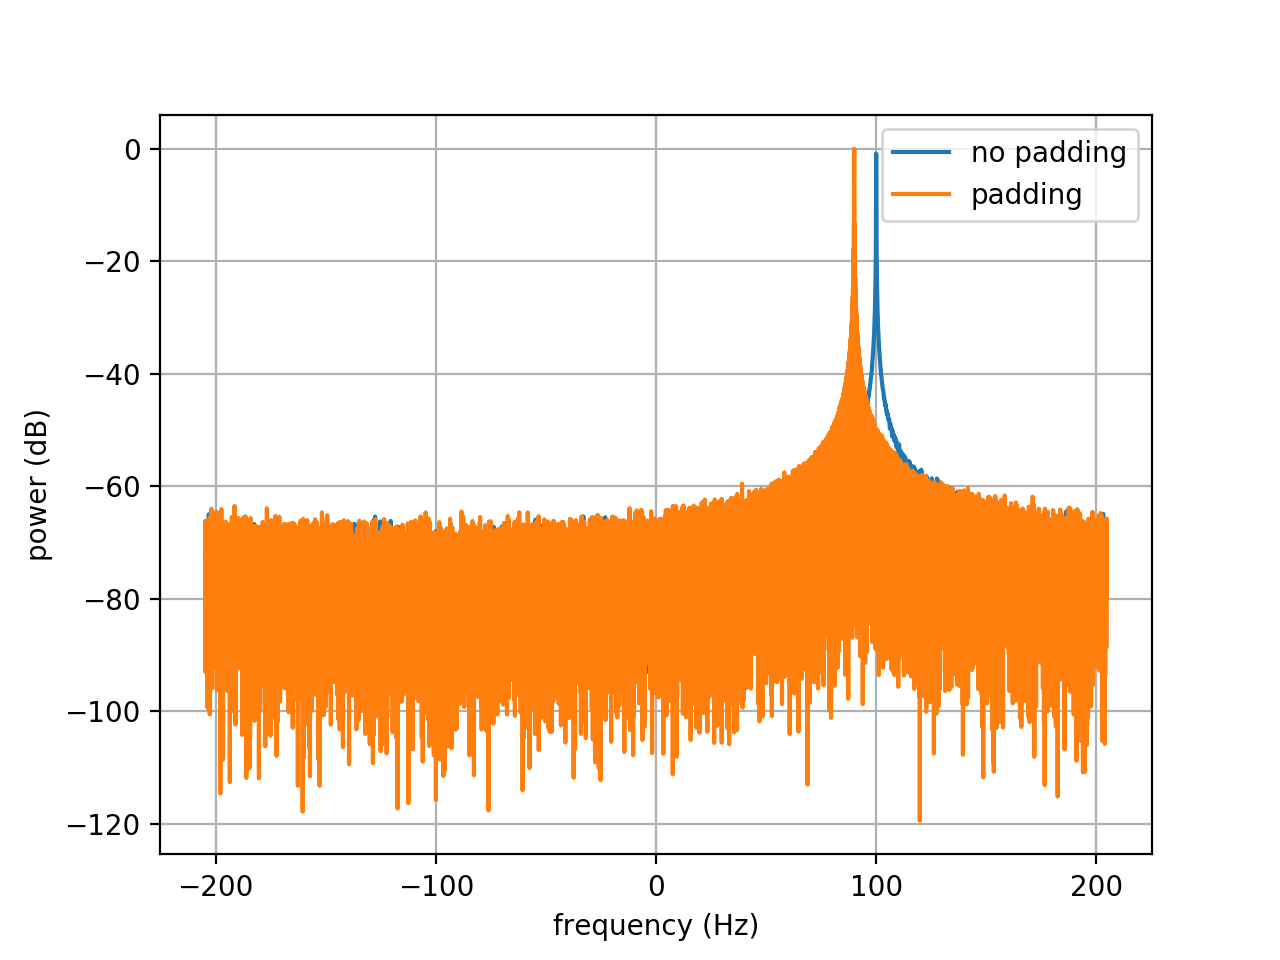

In [17]:
# helper function for making phasors
def wave_complex(f, tmax, N = 2**10):
    '''
    creates a phasor.
    Call:
        t, y = wave_complex(f, tmax, N = 2**10)
    Input:
        f: float, frequency in Hz
        tmax: float, max time in s
        N: number of samples
    Return:
        t: time array
        y: the complex phasor
    '''
    t = np.linspace(0,tmax,N)
    omega = 2 * np.pi * f
    return t, np.sin(omega * t) - 1j* np.cos(omega * t)

# create two wave at shifted frequencies
t, y = wave_complex(100,10, N=2**12)
t1, y1 = wave_complex(90,10, N=2**12)
y+=noise(.01, len(t))
y1+=noise(.01, len(t1))

# fft
f1,s1,S1,PSD1 = FFT(t, y) # no padding
f2,s2,S2,PSD2 = FFT(t1, y1, N = 2**18) # zero padding

# plot
plt.figure()
plt.plot(f1, PSD1, label = "no padding")
plt.plot(f2, PSD2, label = "padding")
plt.xlabel("frequency (Hz)")
plt.ylabel("power (dB)")
plt.legend()
plt.grid()
plt.show()


## What are all those garbage ripples in the zero-padded signal?
Remember, abrupt changes in the time domain result in many frequency components in the Fourier domain. 

Those are an artifact of the signal abruptly turning off before the padded region. We improve those those by applying FFT windows. 

Windows are nice and useful. Some people are overly passionate about which one they like the best. If you are new to window shopping, start with a Hanning or Hamming.

Windows in general drop the overal signal amplitude, so beware. 

<IPython.core.display.Javascript object>


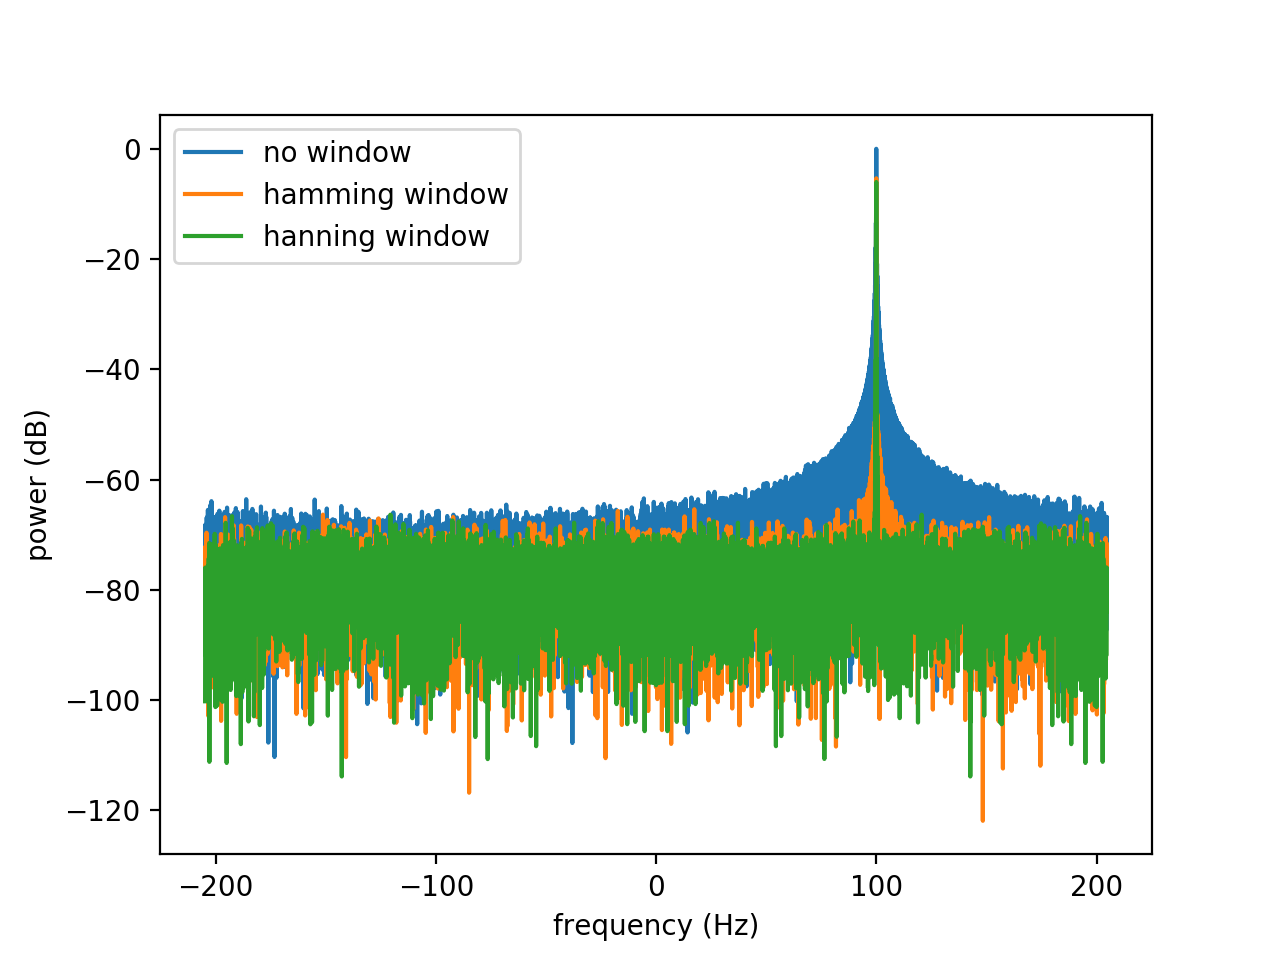

In [18]:
t, y = wave_complex(100,10, N=2**12)

f1,s1,S1,PSD1 = FFT(t, y+noise(.01, len(y)), N = 2**14)
f2,s2,S2,PSD2 = FFT(t, np.hamming(len(y)) * y+noise(.01, len(y)), N = 2**14)
f3,s3,S3,PSD3 = FFT(t, np.hanning(len(y)) * y+noise(.01, len(y)), N = 2**14)

plt.figure()
plt.plot(f1, PSD1, label = "no window")
plt.plot(f2, PSD2, label = "hamming window")
plt.plot(f3, PSD3, label = "hanning window")
plt.legend()
# plt.xlim(99,101)
plt.xlabel("frequency (Hz)")
plt.ylabel("power (dB)")
plt.show()

# Filtering via FFT
You can implement filters in the Fourier domain pretty easily. I'll show you a low pass filters. There are much more elegant ones that this of course. 


<IPython.core.display.Javascript object>


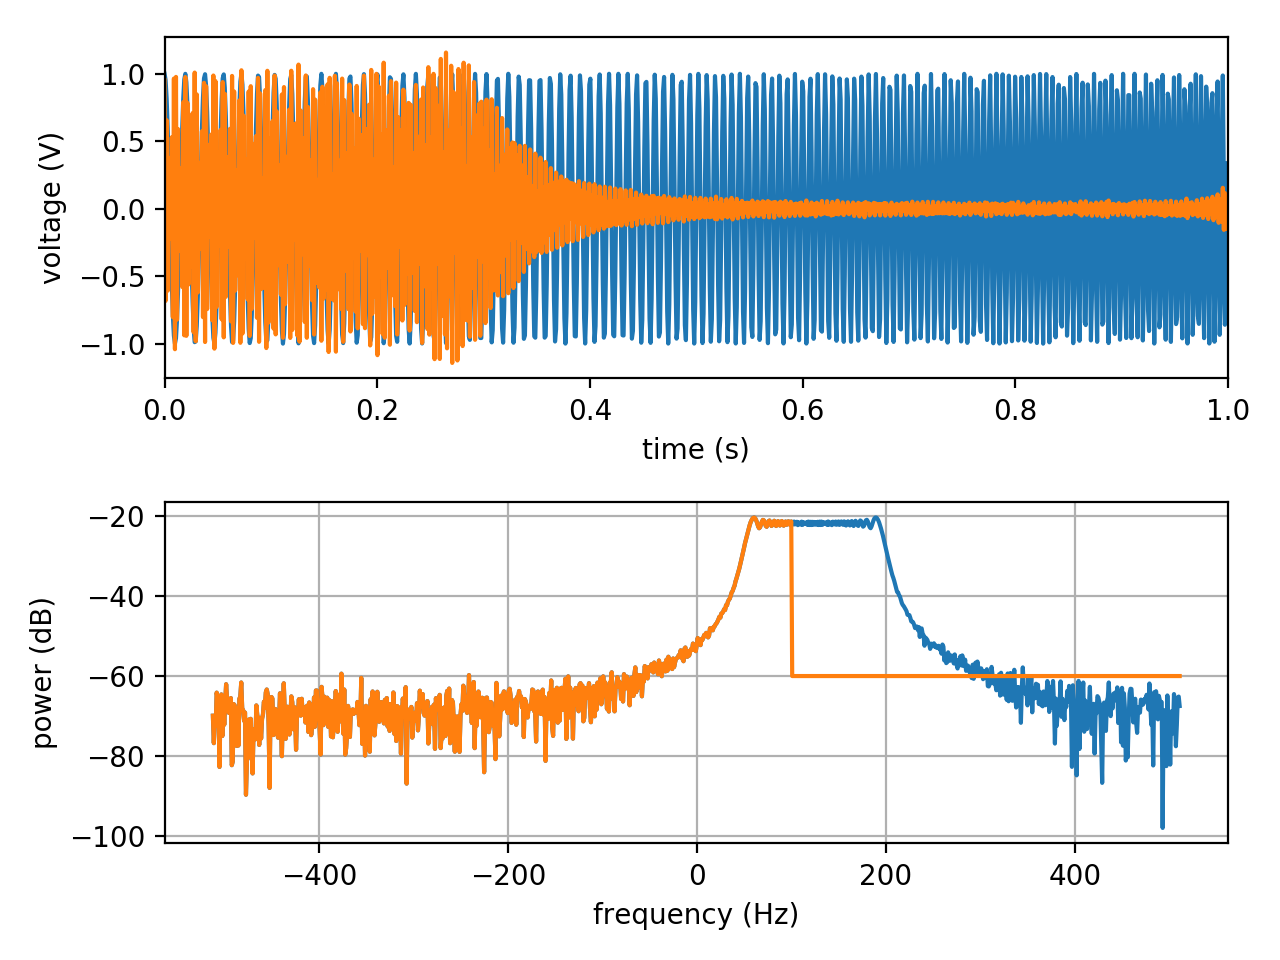

In [19]:
def chirp(f1,f2, N = 2**10):
    t = np.arange(0,1,1/N)
    omega = 2 * np.pi * (f1 + 0.5 * (f2 - f1) * t) 
    return t, np.exp(1j * omega * t)

t1, y1 = chirp(50,200)
f1,s1,S1,PSD1 = FFT(t1, y1+noise(.01, len(y1)))

locs = np.where(f1 > 100)[0]
s1[locs] = np.ones(len(locs)) * 1e-3
y1_inv = len(s1)*fft.ifft(s1)


## oritinal signals
_, ax = plt.subplots(2)
ax[0].plot(t1, y1.real, label = "before filter")
ax[0].plot(t1, y1_inv.real, label = "after filter")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("voltage (V)")
ax[0].set_xlim(0,1)

ax[1].plot(f1, PSD1, label = "before filter")
ax[1].plot(f1, 10*np.log10(np.abs(s1)**2), label = "after filter")

ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dB)")

plt.grid()
plt.tight_layout()
plt.show()

# Filtering tools in Scipy
There are a ton of filtering tools in Scipy - a lot of them work really well. Check it out in the [scipy package](https://docs.scipy.org/doc/scipy-0.14.0/reference/signal.html)

<IPython.core.display.Javascript object>


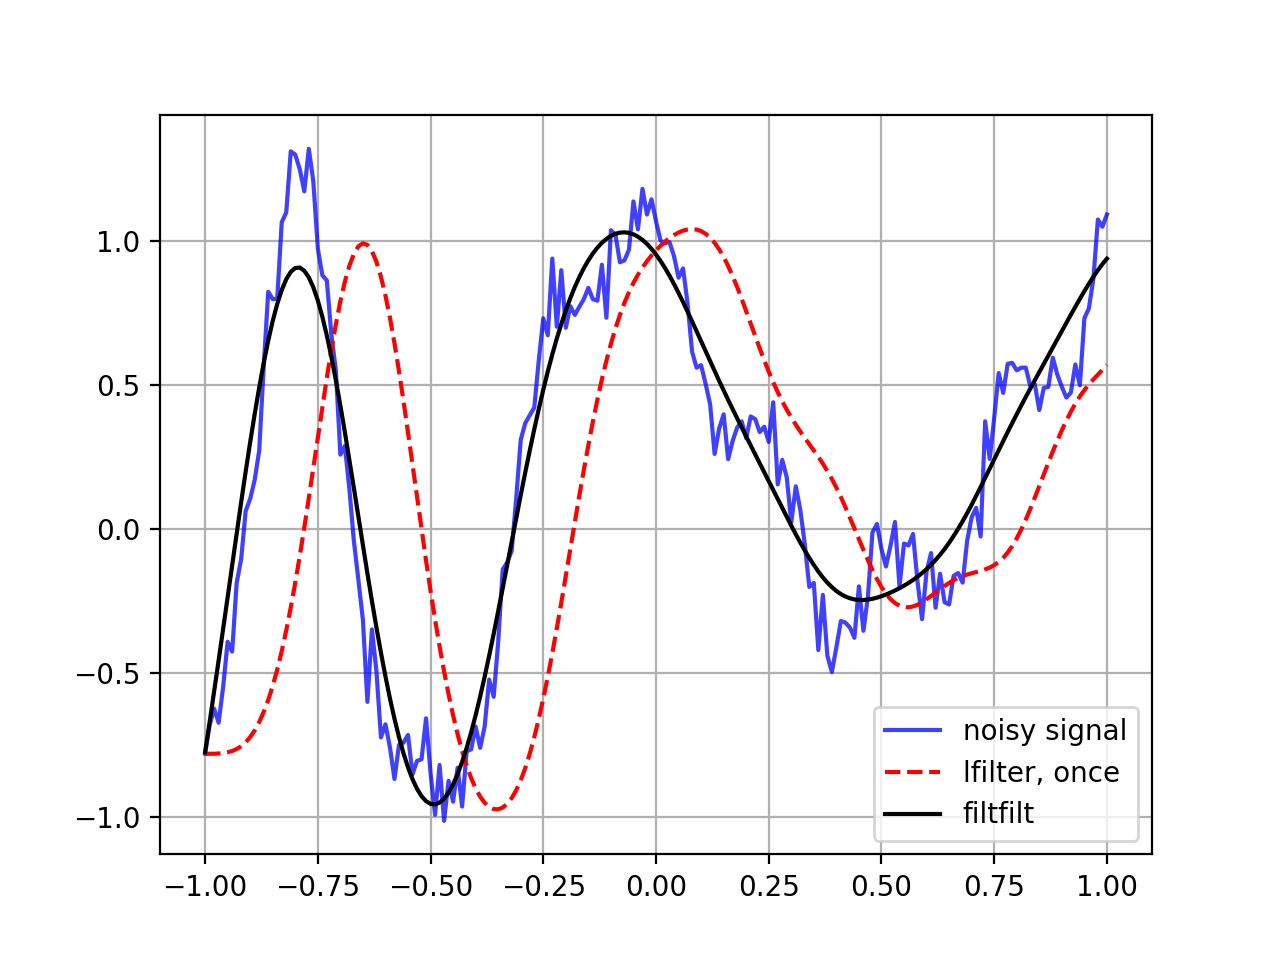

In [20]:
from scipy import signal
# create a simple signal
t = np.linspace(-1, 1, 201)
x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +
     0.1*np.sin(2*np.pi*1.25*t + 1) +
     0.18*np.cos(2*np.pi*3.85*t))
xn = x + np.random.randn(len(t)) * 0.08

# low pass filter
b, a = signal.butter(3, 0.05,btype='low', analog=False)

# apply the filter in a couple ways
zi = signal.lfilter_zi(b, a) #initial contitions
z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0]) # apply once
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
y = signal.filtfilt(b, a, xn) # use to apply once forward and once backward.

# plot
plt.figure()
plt.plot(t, xn, 'b', alpha=0.75)
plt.plot(t, z, 'r--',t, y, 'k')
plt.legend(('noisy signal', 'lfilter, once',
            'filtfilt'), loc='best')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


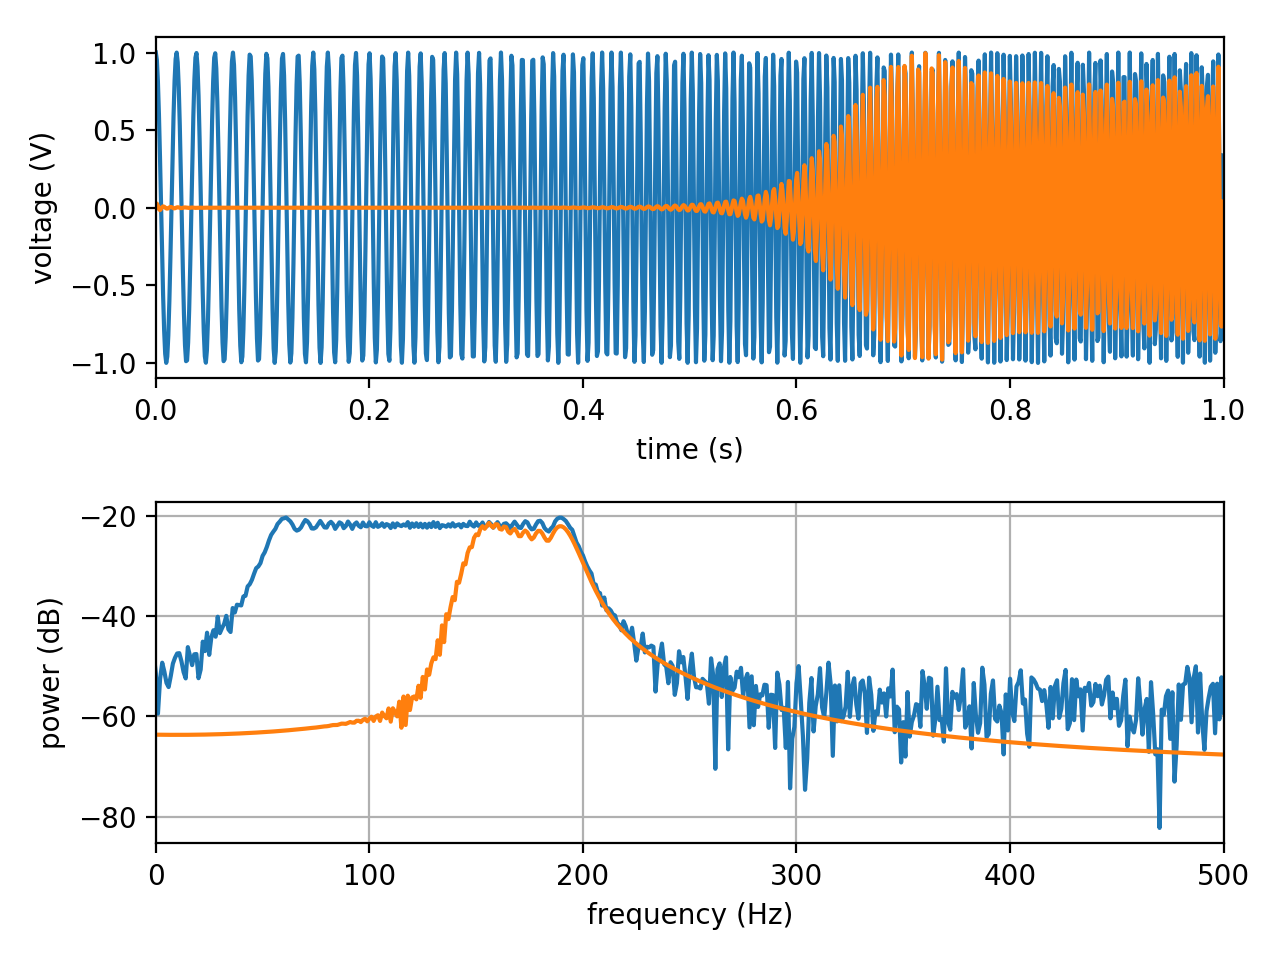

In [21]:
t1, y1 = chirp(50,200)
f1,s1,S1,PSD1 = FFT(t1, y1+noise(.05, len(y1)))
fs= len(t1)/(t1[1]-t[0])

# low pass filter
b, a = signal.cheby1(5,1, 2*150 / fs , btype='high', analog=False)
# b, a = signal.butter(5,2*150 / fs , btype='low', analog=False)
# b,a = signal.iirnotch(2*150 / fs, 100)
z = signal.filtfilt(b, a, y1) # apply once
f2,s2,S2,PSD2 = FFT(t1, z)

_, ax = plt.subplots(2)
ax[0].plot(t1, y1.real, label = "before filter")
ax[0].plot(t1, z.real, label = "after filter")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("voltage (V)")
ax[0].set_xlim(0,1)

ax[1].plot(f1, PSD1, label = "before filter")
ax[1].plot(f2, PSD2, label = "after filter")

ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (dB)")
ax[1].set_xlim(0,500)

plt.grid()
plt.tight_layout()
plt.show()

## Phase matters
You can also extract the phase of a signal using the FFT. Some people call this a [Hilbert transform](https://en.wikipedia.org/wiki/Hilbert_transform). You are able to do this because the amplitudes that result from an FFT are in general complex. I'll show you an example for a chirp.

Also, be warned, just because two signals have the same power spectrum does not mean the time-domain is the same. I'll provide an example of this. It is important to remember that PSD isn't everything, nor is it complete information. 


<IPython.core.display.Javascript object>


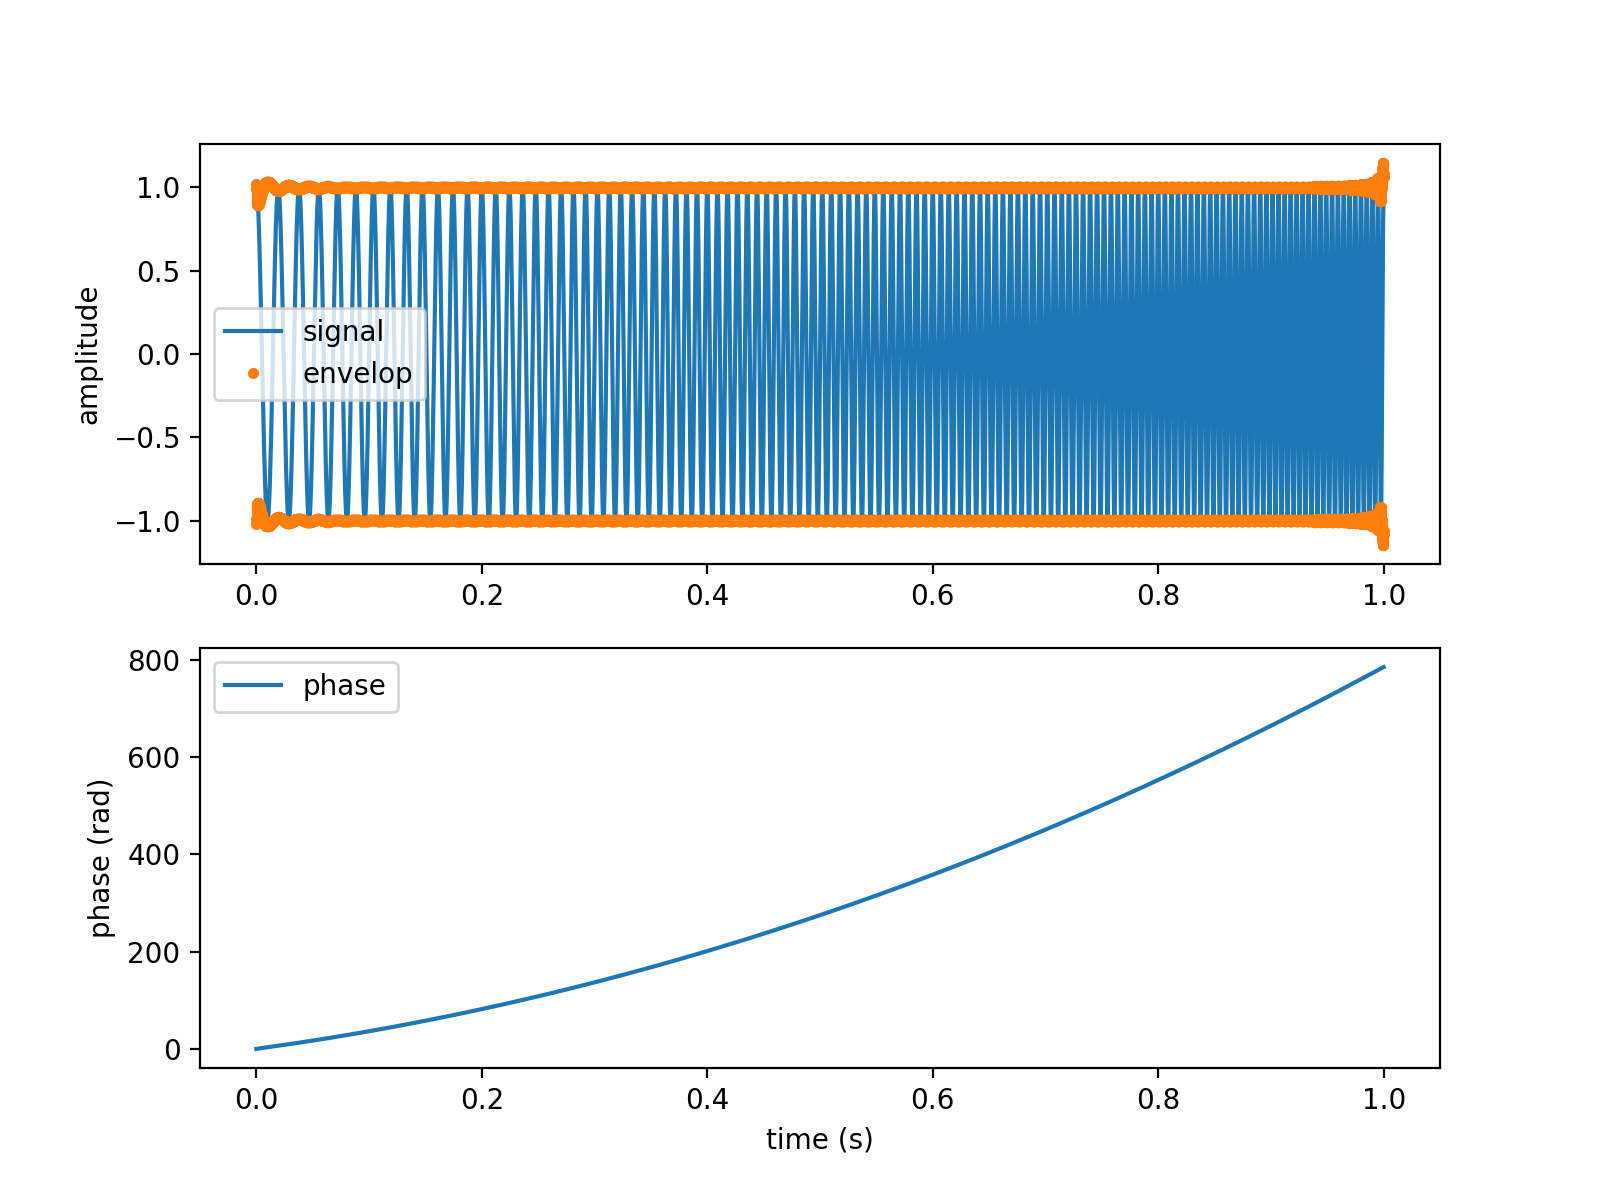

In [22]:
t1, y1 = chirp(50,200, N = 2 **14)

def analytic_signal(x):

    X = fft.fft(x,len(x))
    h = np.zeros(len(x))
    h[0] = 1
    h[1:len(x)//2] = np.ones(len(x)//2-1)
    h[len(x)//2] = 1
    Z = X*h
    z = fft.ifft(Z,len(x))
    return z

z = analytic_signal(y1)
env = np.abs(z)
phase = np.unwrap(np.angle(z))

_, ax = plt.subplots(2, figsize = (8,6))
ax[0].plot(t1, y1.real, label  = "signal")
ax[0].plot(np.concatenate((t1,t1)), np.concatenate((env,-env)),'.', label = "envelop")
ax[0].legend()
ax[0].set_ylabel("amplitude")
ax[1].plot(t1, phase, label = "phase")
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel("phase (rad)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


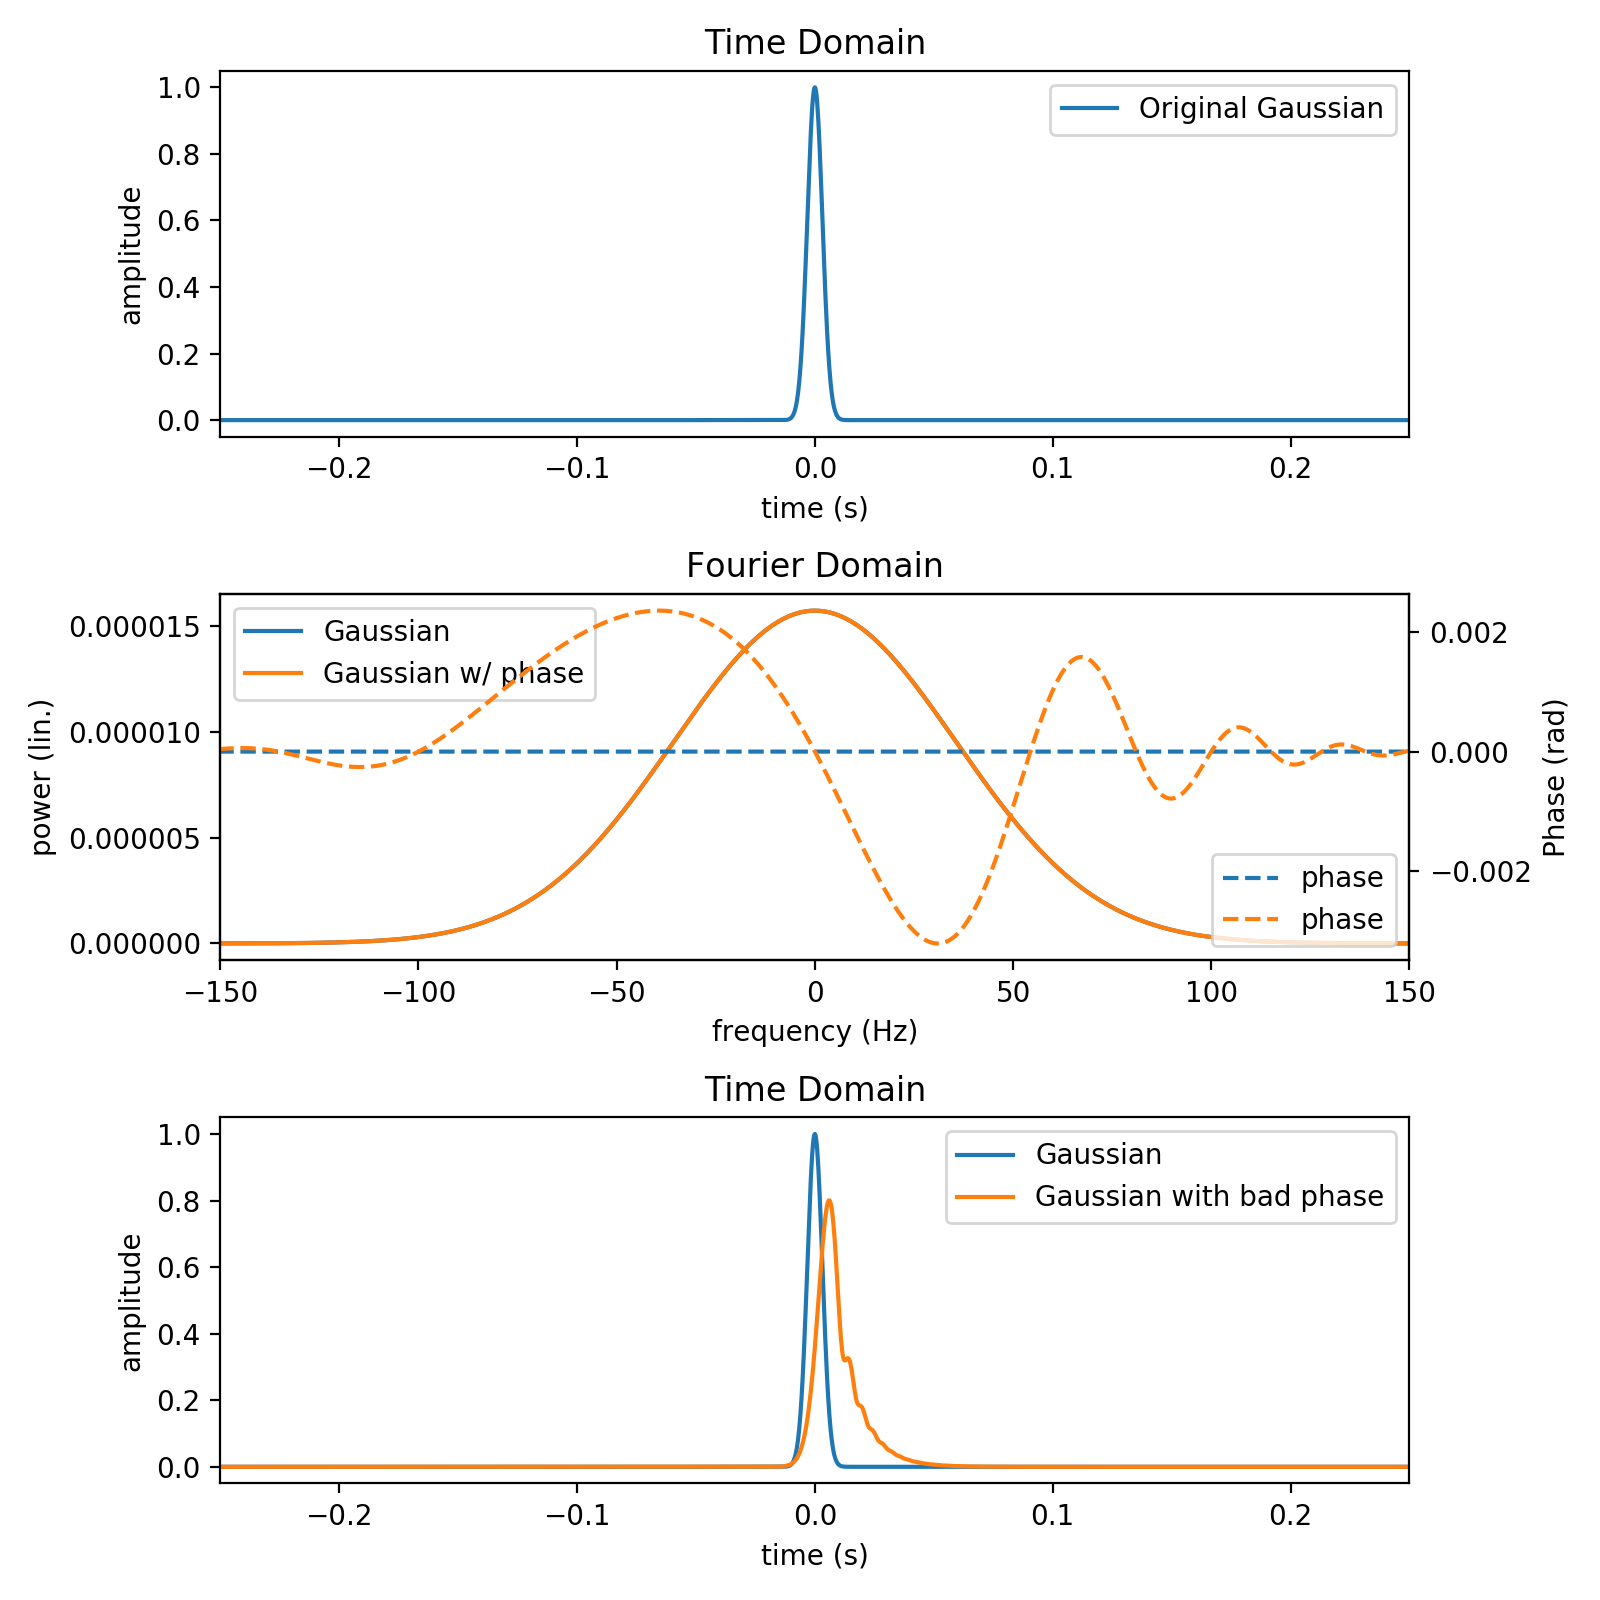

In [23]:
# make a gausian signal
t = np.arange(-1,1,1/N)
gaussian1 = np.exp(-t**2/.00002)+noise(1e-6,len(t))

# fft it
f1,s1,S1,PSD1 = FFT(t,gaussian1)
N = len(f1)

# take the same output from the FFT above and mess with the phase only
s2 = np.abs(s1)* np.exp(-.01j * np.pi * f1 ** 1) * np.exp(-.0001j * np.pi * f1 ** 2) * np.exp(-.000001j * np.pi * f1 ** 3) 

#plots
_,ax = plt.subplots(3, figsize=(8,8))
ax[0].plot(t, gaussian1, label = "Original Gaussian")
ax[0].set_xlim(-.25,.25)
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")
ax[0].legend()

ax[1].plot(f1, np.abs(s1)**2, label = "Gaussian")
ax[1].plot(f1, np.abs(s2)**2, label = "Gaussian w/ phase")
ax2 = ax[1].twinx()
ax2.plot(f1, s1.imag,'--', label = "phase")
ax2.plot(f1, s2.imag,'--', label = "phase")
ax2.legend(loc = "lower right")
ax2.set_ylabel("Phase (rad)")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (lin.)")
ax[1].set_title("Fourier Domain")
ax[1].set_xlim(-150,150)
ax[1].legend(loc = "upper left")

ax[2].plot(t, gaussian1, label = "Gaussian")
ax[2].plot(t, np.abs(fft.fftshift(len(s2)*fft.ifft(s2))), label="Gaussian with bad phase")
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel("amplitude")
ax[2].set_title("Time Domain")
ax[2].set_xlim(-.25,.25)
ax[2].legend()
plt.tight_layout()
plt.show()

# Digitizers and I/Q sampling
## what is I/Q smapling?
I'm sure you have all heard about block up converters and block down converters. Their key feature is that they are able to "multiply" two (or any) frequencies together and get the resulting sum and difference. This works because of basic trigonometry and [trigonometric identities](https://en.wikipedia.org/wiki/List_of_trigonometric_identities).

Fist let's take $sin(\omega_1 t + \phi_1) \times sin(\omega_2 t + \phi_2)$. From this you get:

&nbsp;&nbsp;&nbsp;&nbsp; $sin(\omega_1 t + \phi_1) \times sin(\omega_2 t + \phi_2) = \frac{1}{2}\left[ cos\left((\omega_1 - \omega_2) t + \phi_1-\phi_2\right)  - cos((\omega_1 + \omega_2) t + \phi_1+\phi_2)\right]$

If you inspect this, you will see that the difference term downconverts, the sum term up converts. If we just  consider downconversion first, the we see something problematic. Assuming we have the two frequencies to be the same, but $\phi_1 = 0$ and $\phi_2 = \pi/2$, we see that this downconverted signal disappears! That's no good, because there actually is a signal there. So, downconverters with this sort or single mixing stage will actually miss things. The way around this is to perform the mixing stage twice. Once with a signal as $LO_1 = \omega_2 t + \phi_2$ and another at  $LO_2 = \omega_2 t + \phi_2 + \pi/2$. This ensures that in either of these two channels the signal will always be present. Further it actually ensurs that you can reconstruct the full amplitude and phase of the signal that came in relative to your reference. If we label the signal from $LO_1$ as $I$ and the signal from $LO_2$ as $Q$, we can combine them as:

&nbsp;&nbsp;&nbsp;&nbsp;$ x(t) = I + j Q$

And, you can rewrite this as:

&nbsp;&nbsp;&nbsp;&nbsp;$x(t) = I + j Q = r e^{i\phi}$,

with:

&nbsp;&nbsp;&nbsp;&nbsp; $r = \sqrt{I^2 + Q^2}$

&nbsp;&nbsp;&nbsp;&nbsp; $\phi  = arg(x)$

## Does I/Q digitizing doubler your bandwidth?
Sort of. Remember, real signals are frequency symmetric (negative frequencies are identical to positive frequencies. So, for only a signal step downconversion (using on the I channel), you can't tell if the signal is above or below the frequency of the LO. So, in effect, this limits to you to only to positive frequencies in the Fourier domain. But, if we can determine the full complex signal, we can tell if the frequency is above or below the LO. This let's us use both positive and negative frequency components in the Fourier domain. 

But, in order to be able to use both positive and negative frequencies, you have to digitize two channels (both IQ). The Nyquist limit of resolvable bandwidth is not violated since we doubled the bandwidth by doubling the amount of digitization. So, there is no free lunch there. 


## What are ENOBs and what does it have to do with FFTs?
At some point, you should read [Understand SINAD, ENOB, SNR, THD, THD + N, and SFDR so
You Don't Get Lost in the Noise Floor](https://www.analog.com/media/en/training-seminars/tutorials/MT-003.pdf)

I think the most useful way to think about this is as follows:
- a N-bit digitizer will try to put the vertical scale in N different levels. 
- Due to noise sources, there will be some voltage fluctuations that there will obfuscate the last few bits effectively reducing the resolution. On top of that, there may be spurious signals present.
- This is ultimately reduced to a number called Signal-To-Noise-And-Distortion (SINAD) which can also be converted to effective-number-of-bits (ENOB)

This means, when simulating or analyzing a digitizer, it is incorrect to calculate the voltage noise floors by simply considering 2$^{ENOB}$. Rather, you should take ENOB (or SINAD) and calculate the noise for that. 

From there, you can simulate the digitizer by adding white noise on top of a quantization of 2$^{BITS}$ **not** 2$^{ENOB}$.


In [24]:
# ADC Parameters
fsc = 250e6
ENOB = 10
BITS = 16
VMax = 1.25

# derived parameters
SINAD = 6.02 * ENOB + 1.76
P0 = 10 * np.log10((VMax /np.sqrt(2)) ** 2 *1e3 / 50) # maximum signal
NF = P0 - SINAD - 13 # noise floor
ADC_STD = 10 ** (NF / 20) / (2*np.sqrt(2)) # voltage rms noise 
print('Vrms of ADC: ' + str(np.round(ADC_STD*1e3, 2)) + ' mVrms')

# signal parameters
f = 15e6
t = np.arange(250e2)*1/fsc
x = VMax * np.cos(2 * np.pi * f * t) + VMax *1e-3 * (np.cos(2*np.pi*(f*2)*t) +  np.cos(2*np.pi*(5.7*f)*t)+ np.cos(2*np.pi*(3*f)*t) )

Vrms of ADC: 0.25 mVrms


In [25]:
# Apply ADC
# Add noise
x += np.random.normal(0, ADC_STD, len(x))

# Add vertical quantization
b = 2 * VMax / 2 ** BITS # NOT ENOBS!
x = np.array([i//b * b for i in x])

# take FFT
f1,s1,S1,PSD1 = FFT(t,x)

<IPython.core.display.Javascript object>


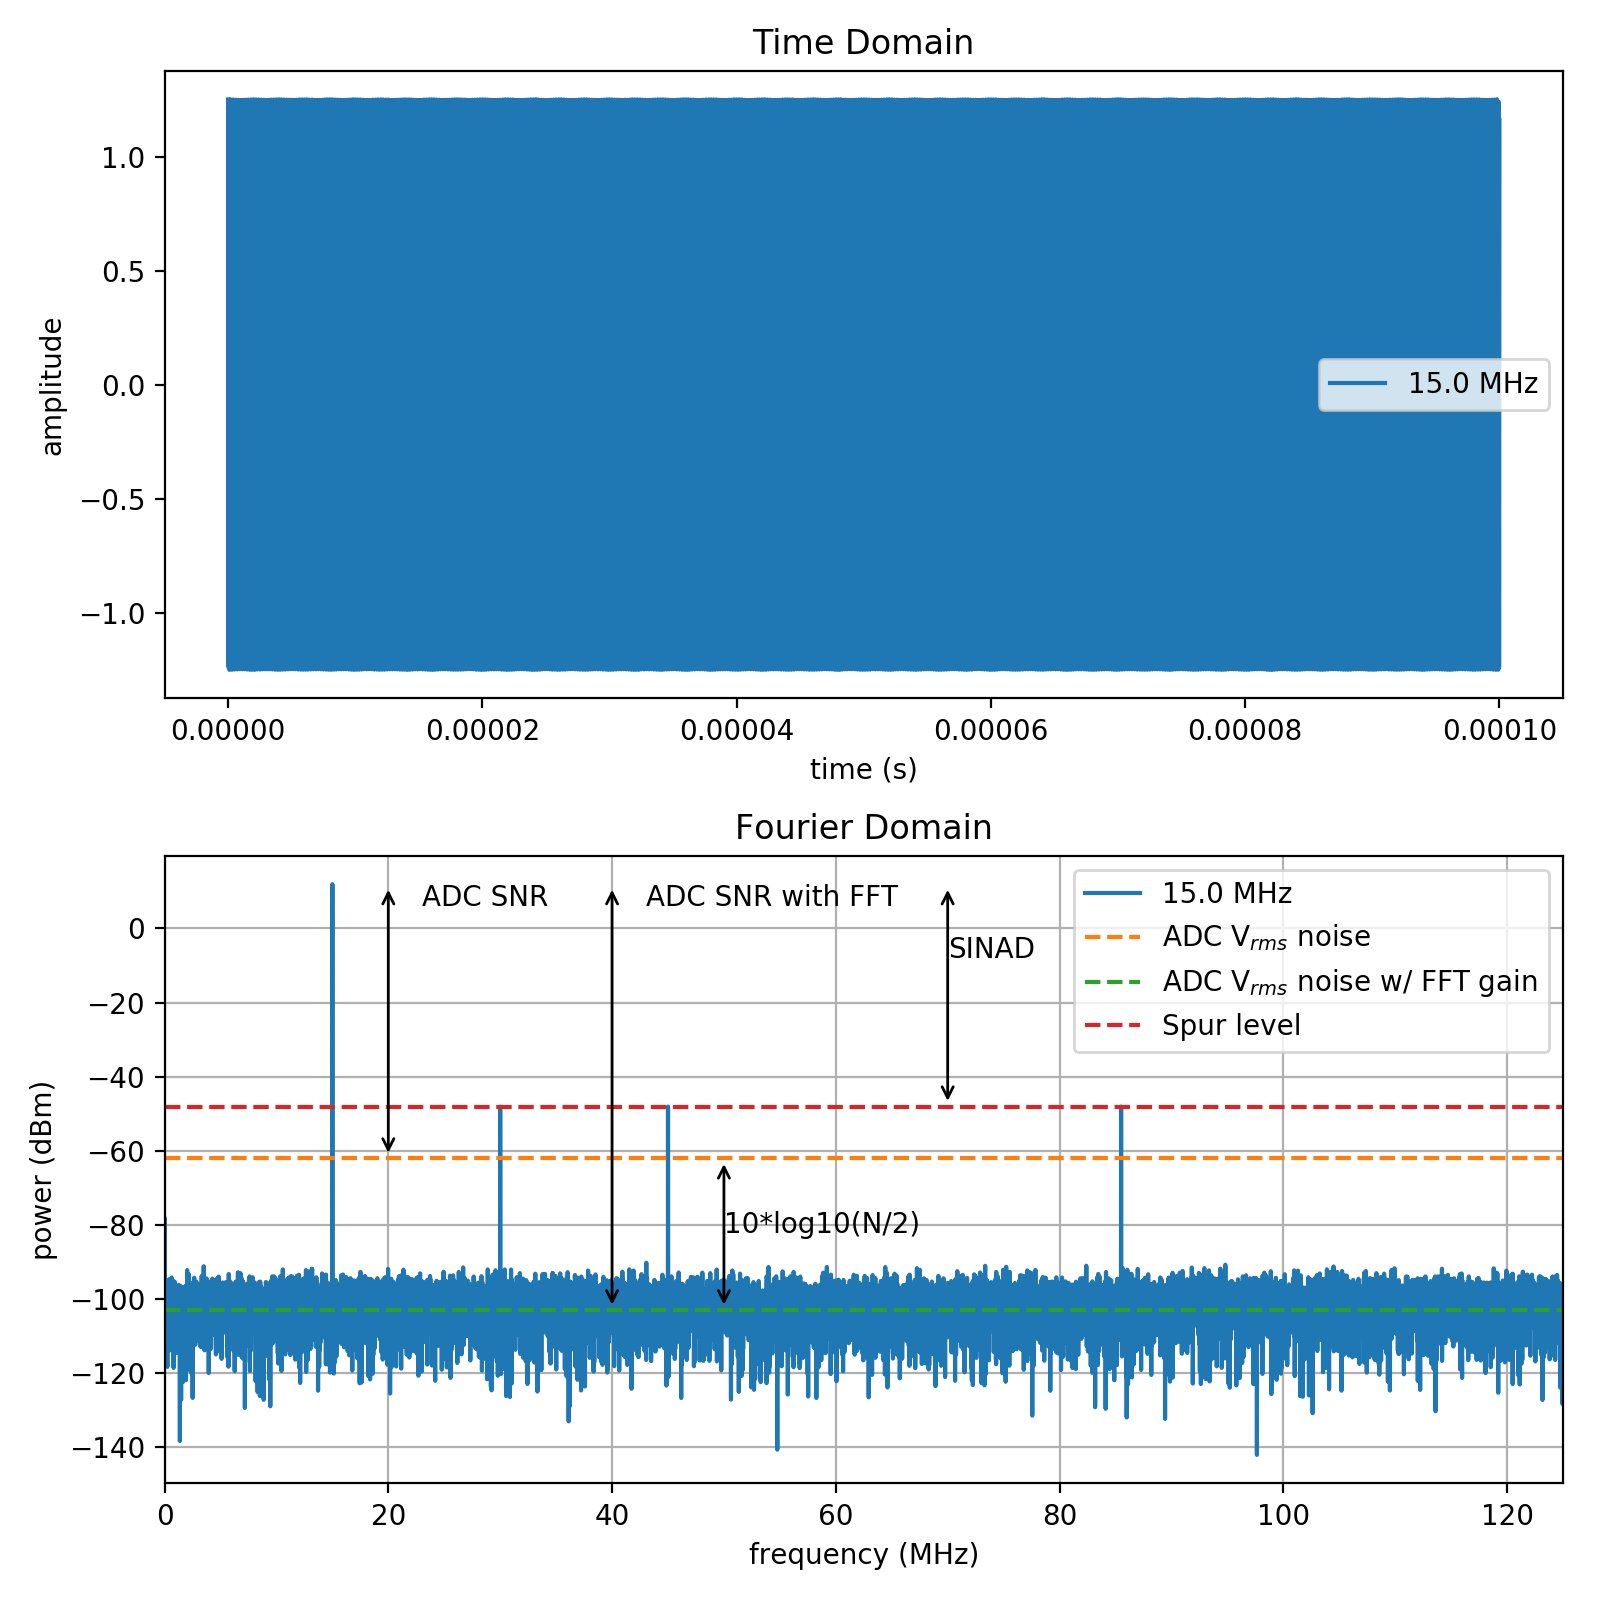

In [26]:
# plots
_,ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(t, x.real, label = f"{f//1e6} MHz")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")
ax[0].legend()

ax[1].plot(f1/1e6, 6 + dBm(PSD1), label = f"{f//1e6} MHz")
adc_noise = 10+20*np.log10(ADC_STD)
# SNR ADC
ax[1].plot([0,125],[adc_noise, adc_noise], 
           '--', label= "ADC V$_{rms}$ noise" )
#FFT GAIN
adc_noise_with_gain = 10+20*np.log10(ADC_STD) - 10*np.log10(len(t)//2)
ax[1].plot([0,125],[adc_noise_with_gain,adc_noise_with_gain], 
           '--', label= "ADC V$_{rms}$ noise w/ FFT gain" )
#SINAD
spur_level = 10+20*np.log10(VMax *1e-3)
ax[1].plot([0,125],[spur_level,spur_level], 
           '--', label= "Spur level" )
# PEAK
ax[1].annotate("", xy=(20, adc_noise), xytext=(20, max(6 + dBm(PSD1))), arrowprops=dict(arrowstyle="<->"))
ax[1].annotate("ADC SNR", xy=(23, adc_noise),xytext=(23, max(dBm(PSD1))))
# SNR ADC
ax[1].annotate("", xy=(40, adc_noise_with_gain), xytext=(40, max(6 + dBm(PSD1))), arrowprops=dict(arrowstyle="<->"))
ax[1].annotate("ADC SNR with FFT", xy=(43, adc_noise_with_gain),xytext=(43, max(dBm(PSD1))))
#FFT GAIN
ax[1].annotate("", xy=(50, adc_noise), xytext=(50,adc_noise_with_gain), arrowprops=dict(arrowstyle="<->"))
ax[1].annotate("10*log10(N/2)", xytext=(50, adc_noise-20),xy=(50,adc_noise_with_gain-20))
#SINAD
ax[1].annotate("", xy=(70, max(6 + dBm(PSD1))), xytext=(70,spur_level), arrowprops=dict(arrowstyle="<->"))
ax[1].annotate("SINAD", xytext=(70, max(6 + dBm(PSD1))-20),xy=(70,spur_level-20))

ax[1].set_xlabel("frequency (MHz)")
ax[1].set_ylabel("power (dBm)")
ax[1].set_title("Fourier Domain")
ax[1].legend(loc = "upper right")
ax[1].set_xlim(0,125)
plt.tight_layout()
ax[1].grid()
plt.show()

# FFT of two delayed signals
Now that we have covered som basics, one import feature to consider is what happens to Fourier transforms of repeating signals. To show this, we will consider two identical pulses separated in time. Why? Because this is why and how TDoA approaches work. 

<IPython.core.display.Javascript object>


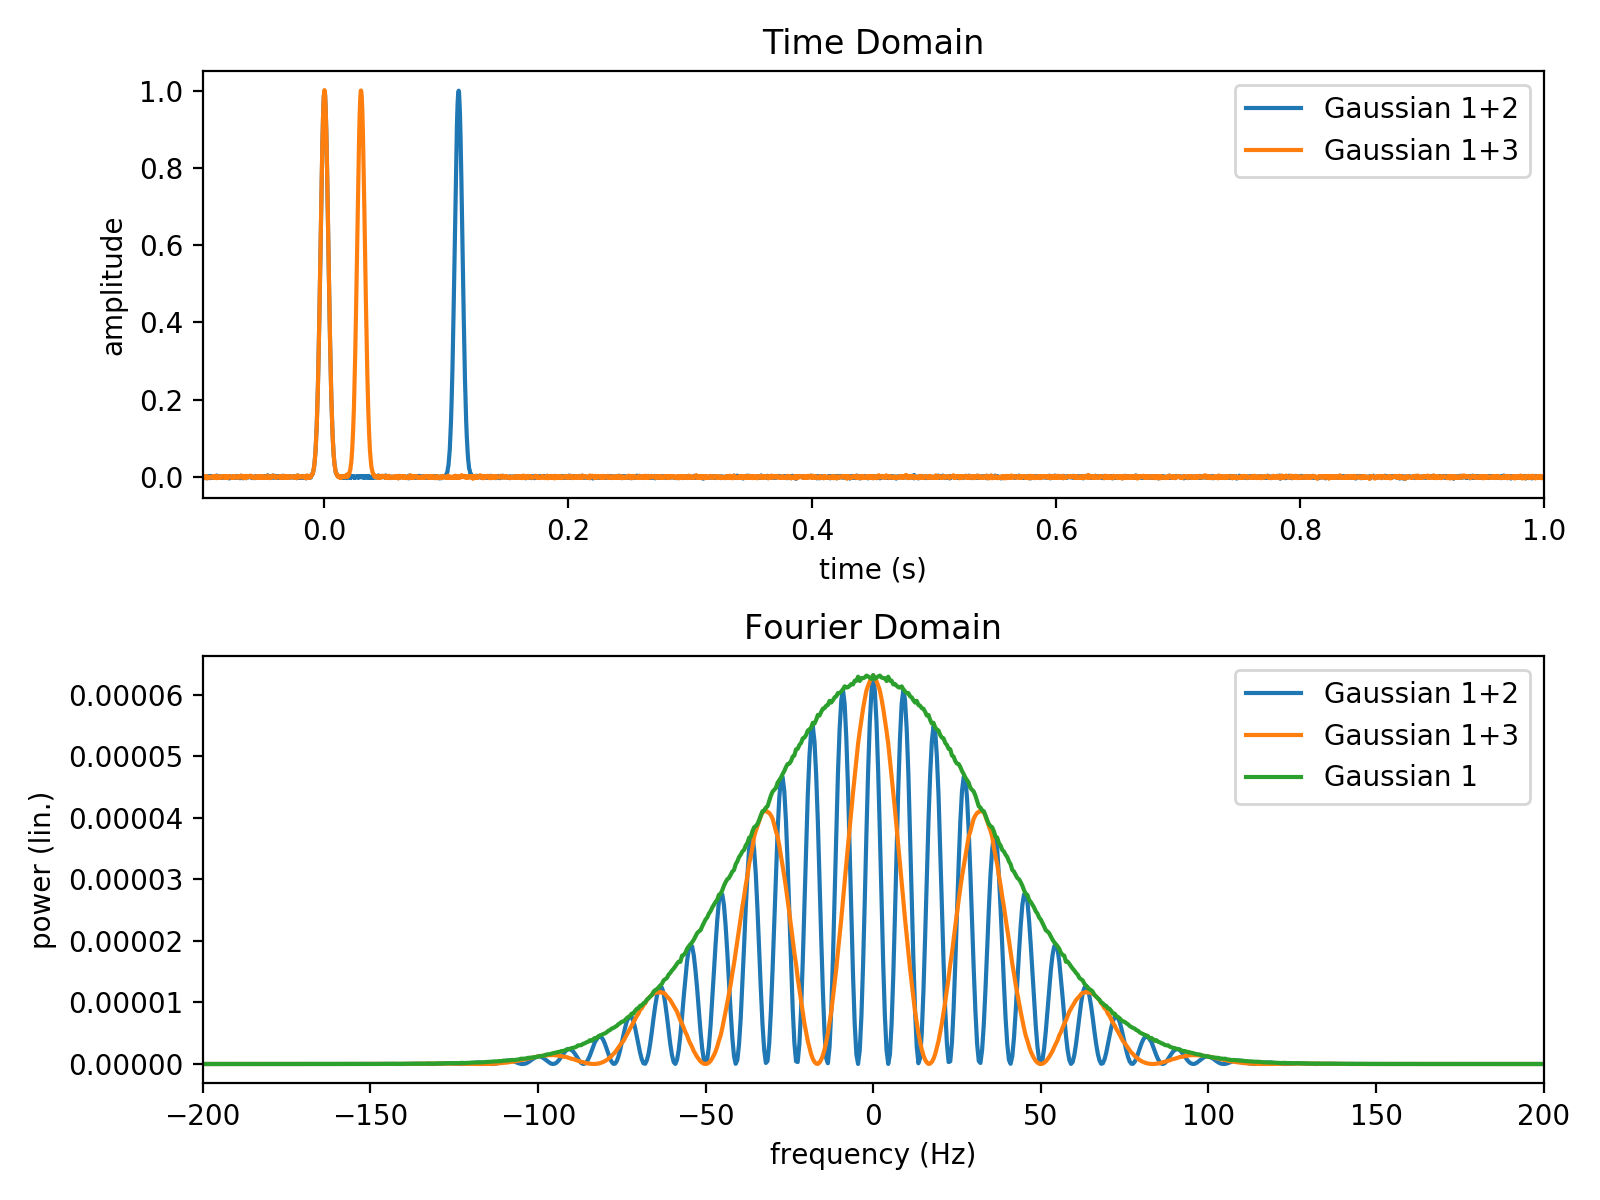

In [27]:
## Gaussians and pulses
N = 2 ** 12
t = np.arange(-1,1,1/N)
gaussian1 = np.exp(-t**2/.00002)+noise(1e-3,len(t))
gaussian2 = np.exp(-(t-.11) **2/.00002)+noise(1e-3,len(t))
gaussian3 = np.exp(-(t-.03) **2/.00002)+noise(1e-3,len(t))
f0,s0,S0,PSD0 = FFT(t,gaussian1)
f1,s1,S1,PSD1 = FFT(t,gaussian1+gaussian2)
f2,s2,S2,PSD2 = FFT(t,gaussian1+gaussian3)

_,ax = plt.subplots(2, figsize = (8,6))
ax[0].plot(t, gaussian1+gaussian2, label = "Gaussian 1+2")
ax[0].plot(t, gaussian1+gaussian3, label = "Gaussian 1+3")
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel("amplitude")
ax[0].set_title("Time Domain")
ax[0].set_xlim(-.1,1)
ax[0].legend()

ax[1].plot(f1, S1, label = "Gaussian 1+2")
ax[1].plot(f2, S2, label = "Gaussian 1+3")
ax[1].plot(f0, S0*4, label = "Gaussian 1")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("power (lin.)")
ax[1].set_title("Fourier Domain")
ax[1].legend()
ax[1].set_xlim(-200,200)
plt.tight_layout()
plt.show()